# Runoff comparison Indus:

Here we compare the runoff estimated from Rounce et al., (2023) to the runoff estimated from OGGM (simulations done by Erik Holmgren using OGGM v. XXX), and to the runoff estimated from OGGM v1.6.

--> we compare different methods for single glaciers and a single gcm here: www_lschuster/provide/runoff_example_data/runoff_method_comparison_oggm_pygem.ipynb

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
basin= 'INDUS'

In [3]:

import geopandas as gpd
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
import json
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
# they  are all either from RGI region 13 or 14

path_oggm_erik = f'/home/www/eholmgren/data/basins/gha_basins/{basin_idx}/'
gcms = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg',
       'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR',
       'MRI-ESM2-0', 'NorESM2-MM']

### Extract information of terminus location of the glaciers 

In [5]:
path_stats_13 = '/home/www/oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/RGI62/b_080/L2/summary/glacier_statistics_13.csv'
path_stats_14 = '/home/www/oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/RGI62/b_080/L2/summary/glacier_statistics_14.csv'
pd_stats_13 = pd.read_csv(path_stats_13)
pd_stats_13 = pd_stats_13[['rgi_id','terminus_lon', 'terminus_lat']]

pd_stats_14 = pd.read_csv(path_stats_14)
pd_stats_14 = pd_stats_14[['rgi_id','terminus_lon', 'terminus_lat']]

pd_stats = pd.concat([pd_stats_13, pd_stats_14])
pd_stats = pd_stats.set_index('rgi_id')
# select the glaciers of the INDUS basin
pd_stats = pd_stats.loc[rgis_basin]
pd_stats.to_csv('glacier_terminus_location_INDUS_basin.csv')
pd_stats

/tmp/ipykernel_3985733/666086889.py:3: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_stats_13 = pd.read_csv(path_stats_13)


terminus_lon  terminus_lat
rgi_id                                    
RGI60-13.00002     77.951262     35.541153
RGI60-13.00188     78.662054     34.858492
RGI60-13.00224     79.169854     34.436261
RGI60-13.00228     79.235076     34.422087
RGI60-13.00229     79.407439     34.419129
...                      ...           ...
RGI60-14.27984     78.974081     33.337359
RGI60-14.27985     79.036696     33.293083
RGI60-14.27986     79.038796     33.287543
RGI60-14.27987     79.098103     33.212602
RGI60-14.27988     79.258021     33.217487

[23424 rows x 2 columns]

### runoff:

In [6]:
# get all files with runoff data (because batch files are used ...)
import os
fpath = '/home/www/lschuster/rounce_2023_data'
rounce_files = os.listdir(fpath)
rounce_files_runoff = []
for f in rounce_files:
    if ('runoff' in f) and ('.xml' not in f):
        rounce_files_runoff.append(f)

In [30]:
xr.open_dataset(fpath+'/R01_glac_runoff_fixed_monthly_1set_2000_2100-ssp245-Batch-25001-26000.nc').glac_runoff_fixed_monthly

<xarray.DataArray 'glac_runoff_fixed_monthly' (model: 12, glacier: 1000,
                                               time: 1212)>
[14544000 values with dtype=float64]
Coordinates:
    RGIId          (glacier) object ...
    Climate_Model  (model) object ...
    lon            (glacier) float64 ...
    lat            (glacier) float64 ...
  * time           (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2100-12-01
Dimensions without coordinates: model, glacier
Attributes:
    long_name:            Glacier-wide runoff
    unit:                 m3
    temporal_resolution:  monthly
    comment:              runoff from a fixed-gauge at glacier terminus that ...
    grid_mapping:         crs

In [7]:
basin = 'INDUS'

import geopandas as gpd
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
import json
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
# they  are all either from RGI region 13 or 14
for r in rgis_basin:
    assert (r[6:9] == '13.') or (r[6:9] == '14.')
    
# for the global comparison, I only look at the sum here ...

text = 'Rounce, D.R., R. Hock, and F. Maussion. 2022. Global PyGEM-OGGM Glacier Projections with RCP and SSP Scenarios, Version 1. [glac_runoff_fixed_monthly, RGI region 13 & 14] Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/P8BN9VO9N5C7. [10-01-2023]. Aggregated by Lilian Schuster.'


run = False
if run:
    
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        drunoff_b = []

        for r in [13,14]:
            if r<10:
                r = f'0{r}'
            else:
                r = str(r)
            for f in rounce_files_runoff:
                if (f'R{r}' in f) and (ssp in f):
                    _drunoff = xr.open_dataset(f'{fpath}/{f}')
                    # for some reason xr.open_mfdataset didn't work 
                    # (probably because glacier id is the same in every file and goes from 0-1000)
                    #_drunoff = _drunoff.groupby('time.year').sum()  # m3 month-1 --> m3 a-1
                    _drunoff = _drunoff.rename_dims({'model':'gcm', 'glacier':'rgi_id'}) #, 'year':'time'})
                    _drunoff = _drunoff.set_index(rgi_id='RGIId')
                    _drunoff
                    #_drunoff = _drunoff.set_index(time='year')
                    _drunoff = _drunoff.set_index(gcm = 'Climate_Model')
                    _drunoff = _drunoff.glac_runoff_fixed_monthly*1000 # m3 to kg
                    _drunoff['ssp'] = ssp
                    drunoff_b.append(_drunoff)
            
        drunoff_basin = xr.concat(drunoff_b, dim = 'rgi_id')
        common_rgis_basin = list(set(drunoff_basin.rgi_id.values).intersection(rgis_basin))
        print(f'amount of glaciers in the basin: {len(rgis_basin)}')
        print(f'amount of simulated glaciers : {len(common_rgis_basin)}')
        drunoff_basin = drunoff_basin.sel(rgi_id =common_rgis_basin) 
        
        #drunoff_basin = xr.open_dataset(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc').glac_runoff_fixed_monthly # *1000 # m3 to kg
        drunoff_basin.attrs['description:'] = 'monthly glacier runoff for almost all glaciers of the Indus basin (two are missing). Runoff is calculated assuming a fixed gauge (i.e., it includes on-glacier and off-glacier runoff as glacier starts to retreat and represents runoff from a fixed gauge at a glacier terminus that does not move over time).'
        #Monthly runoff assuming a fixed gauge at a glacier 
    #terminus that does not move over time 
        drunoff_basin.attrs['unit:'] = 'kg month-1'
        drunoff_basin.attrs['data source:'] = text
        assert np.all(drunoff_basin.sel(time='2100-06-01').sum(dim='rgi_id') != 0)
        drunoff_basin.to_netcdf(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc')
else:
    drunoff_basin_rounce_ssp = {}
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:

        drunoff_basin_rounce_ssp[ssp] = xr.open_dataset(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc')

### get the area instead:

In [6]:
# get all files with area data (because batch files are used ...)
import os
fpath = '/home/www/lschuster/rounce_2023_data'
rounce_files = os.listdir(fpath)
rounce_files_glac_area = []
for f in rounce_files:
    if ('glac_area_annual_50sets' in f) and ('.xml' not in f):
        rounce_files_glac_area.append(f)

In [9]:
       
basin = 'INDUS'

import geopandas as gpd
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
import json
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
# they  are all either from RGI region 13 or 14
for r in rgis_basin:
    assert (r[6:9] == '13.') or (r[6:9] == '14.')
    
# for the global comparison, I only look at the sum here ...

text = 'Rounce, D.R., R. Hock, and F. Maussion. 2022. Global PyGEM-OGGM Glacier Projections with RCP and SSP Scenarios, Version 1. [glac_area_annual, RGI region 13 & 14] Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/P8BN9VO9N5C7. [10-01-2023]. Aggregated by Lilian Schuster.'


run = False
if run:
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        darea_b = []

        for r in [13,14]:
            if r<10:
                r = f'0{r}'
            else:
                r = str(r)
            for f in rounce_files_glac_area:
                if (f'R{r}' in f) and (ssp in f):
                    _darea = xr.open_dataset(f'{fpath}/{f}')
                    # for some reason xr.open_mfdataset didn't work 
                    # (probably because glacier id is the same in every file and goes from 0-1000)
                    #_drunoff = _drunoff.groupby('time.year').sum()  # m3 month-1 --> m3 a-1
                    _darea = _darea.rename_dims({'model':'gcm', 'glacier':'rgi_id'}) #, 'year':'time'})
                    _darea = _darea.set_index(rgi_id='RGIId')
                    #_drunoff = _drunoff.set_index(time='year')
                    _darea = _darea.set_index(gcm = 'Climate_Model')
                    _darea['area'] = _darea['glac_area_annual']
                    _darea = _darea.area 
                    _darea['ssp'] = ssp
                    darea_b.append(_darea)
            
        darea_basin = xr.concat(darea_b, dim = 'rgi_id')
        common_rgis_basin = list(set(darea_basin.rgi_id.values).intersection(rgis_basin))
        print(f'amount of glaciers in the basin: {len(rgis_basin)}')
        print(f'amount of simulated glaciers : {len(common_rgis_basin)}')
        darea_basin = darea_basin.sel(rgi_id =common_rgis_basin) 
        
        #drunoff_basin = xr.open_dataset(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc').glac_runoff_fixed_monthly # *1000 # m3 to kg
        darea_basin.attrs['description:'] = 'glacier area evolution'
        #Monthly runoff assuming a fixed gauge at a glacier 
        #terminus that does not move over time 
        darea_basin.attrs['unit:'] = 'm2'
        darea_basin.attrs['data source:'] = text
        
        #assert np.all(darea_basin.sel(time='2100-06-01').sum(dim='rgi_id') != 0)
        darea_basin.to_netcdf(f'for_fahad/area_rounce_{basin}_{ssp}.nc')
else:
    darea_basin_rounce_ssp = {}
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:

        darea_basin_rounce_ssp[ssp] = xr.open_dataset(f'for_fahad/area_rounce_{basin}_{ssp}.nc')

In [23]:
xr.open_dataset('./for_fahad/area_rounce_INDUS_ssp126.nc').area

<xarray.DataArray 'area' (gcm: 12, rgi_id: 23424, year: 102)>
[28670976 values with dtype=float64]
Coordinates:
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2097 2098 2099 2100 2101
  * rgi_id   (rgi_id) object 'RGI60-14.26870' ... 'RGI60-14.16511'
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      object ...
Attributes:
    long_name:            Glacier area
    temporal_resolution:  annual
    units:                m2
    comment:              area at start of the year
    grid_mapping:         crs
    description::         glacier area evolution
    unit::                m2
    data source::         Rounce, D.R., R. Hock, and F. Maussion. 2022. Globa...
    coordinates:          lon lat Climate_Model RGIId

In [20]:
darea_basin.isel(year=-1).where(darea_basin.isel(year=-1)!=0).dropna(dim='rgi_id')

<xarray.DataArray 'area' (gcm: 12, rgi_id: 1209)>
array([[ 862655.67642581,   11649.61450761,   43873.26024531, ...,
        3534114.15883217,  237472.98506712,   16855.62211932],
       [1261587.68789969,   11531.82940832,   43498.57830669, ...,
        2031131.61805209,  257678.3889862 ,   20311.29401576],
       [1366226.00742894,   11768.24818609,   43318.10858468, ...,
        2035933.29573755,  277005.77875329,   20311.29401576],
       ...,
       [1358318.38756374,   11738.061399  ,   67742.23828215, ...,
        6903747.58379304,  512115.07236148,   20311.29401576],
       [2356095.56813629,   11485.35955636,   42604.41865651, ...,
        2937876.70362377,  790010.16224168,   20311.29401576],
       [1704805.8030851 ,   11732.2258039 ,   66985.52942439, ...,
        3453157.22099302,  429550.01053918,   20311.29401576]])
Coordinates:
    lon      (rgi_id) float64 74.11 72.19 77.9 77.06 ... 75.26 76.11 74.26 76.19
    lat      (rgi_id) float64 36.38 35.77 31.7 32.73 ... 36.88 33.44 36.89 35.44
    year     int64 2101
  * rgi_id   (rgi_id) object 'RGI60-14.03563' ... 'RGI60-14.07503'
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      <U6 'ssp585'
Attributes:
    long_name:            Glacier area
    temporal_resolution:  annual
    units:                m2
    comment:              area at start of the year
    grid_mapping:         crs
    description::         glacier area evolution
    unit::                m2
    data source::         Rounce, D.R., R. Hock, and F. Maussion. 2022. Globa...

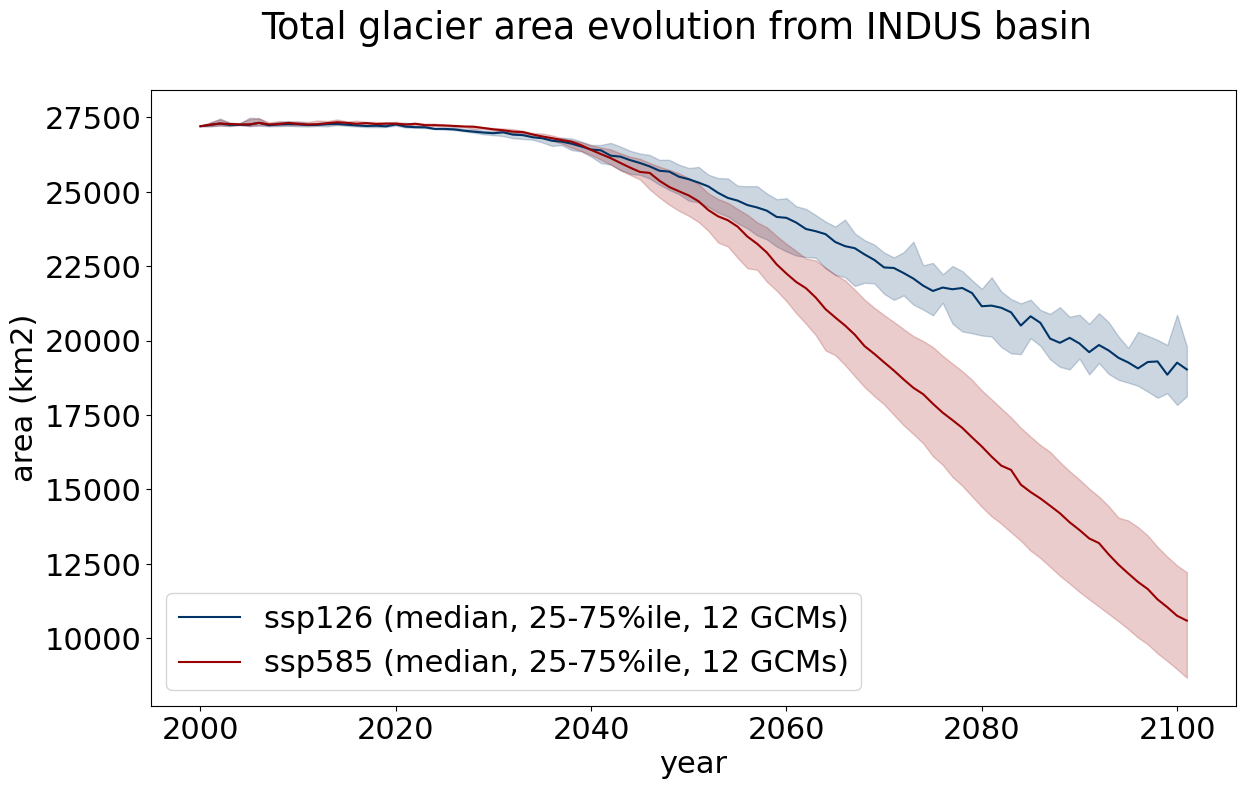

In [15]:
plt.rc('font', size=22)

colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}
fig, ax = plt.subplots(1,1, figsize=(14,8), sharey=True, sharex=True)
for ssp in ['ssp126', 'ssp585']:

    db_rounce = darea_basin_rounce_ssp[ssp]/1e6 # m2 to km2 to Mega Tonnes

    db_rounce_yr_sum = db_rounce.area.sum(dim='rgi_id')
    #db_rounce_yr_sum = db_rounce_yr_sum.sel(year = slice(2020,2099))
    #db_rounce_yr_sum = db_rounce_yr_sum.rolling({'year':3}).mean()

    n_gcm = len(db_rounce_yr_sum.gcm)
    
    sns.lineplot(x='year', y='area (km2)',
                 data=db_rounce_yr_sum.to_dataframe(name='area (km2)').reset_index(),
                 estimator=np.median,ax=ax,errorbar=('pi', 50),
                 ls = '-', label=f'{ssp} (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    #ax.fill_between(db_rounce_yr_sum.year,
    #             db_rounce_yr_sum.quantile(0.25, dim='gcm'),
    #             db_rounce_yr_sum.quantile(0.75, dim='gcm'), alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
    #ax.set_ylim([18000,46000])
    ax.set_xlabel('year')
    ax.set_ylabel(f'area (km2)')
        
#plt.tight_layout()
plt.suptitle(f'Total glacier area evolution from {basin} basin')
#plt.savefig(f'annual_glacier_runoff_{basin}.png')
plt.savefig('for_fahad/annual_glacier_area_evolution_Indus.png')

In [14]:
xr.open_dataset('BCC-CSM2-MR_ssp585.nc').area.sum(dim='rgi_id')/1e6

<xarray.DataArray 'area' (time: 81)>
array([34357.95  , 34280.99  , 34215.387 , 34162.484 , 34178.492 ,
       34082.918 , 34020.58  , 34058.508 , 33891.47  , 33839.02  ,
       33715.01  , 33744.797 , 33618.258 , 33482.81  , 33372.523 ,
       33286.41  , 33145.11  , 33070.875 , 33215.348 , 32869.895 ,
       32705.7   , 32592.934 , 32383.156 , 32157.914 , 31994.863 ,
       31765.959 , 31908.54  , 31379.496 , 31041.059 , 30854.506 ,
       30638.01  , 30371.191 , 30047.613 , 29675.621 , 29315.379 ,
       29019.947 , 28447.281 , 28031.45  , 27606.912 , 26852.445 ,
       26377.83  , 25822.45  , 25129.336 , 24372.604 , 23721.61  ,
       23257.338 , 22656.05  , 21781.678 , 21159.922 , 20467.223 ,
       19974.305 , 19342.895 , 18817.152 , 17679.863 , 17270.387 ,
       16431.309 , 15825.784 , 15097.484 , 14615.607 , 14350.192 ,
       13731.659 , 13225.485 , 12927.309 , 12267.748 , 11778.892 ,
       11384.041 , 11758.571 , 11026.897 , 10290.394 ,  9950.551 ,
        9603.716 ,  9435.831 ,  9043.37  ,  8772.6455,  8393.718 ,
        8294.797 ,  7961.6606,  8083.894 ,  7520.426 ,  7161.3066,
        7035.2793], dtype=float32)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.099e+03 2.1e+03
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...

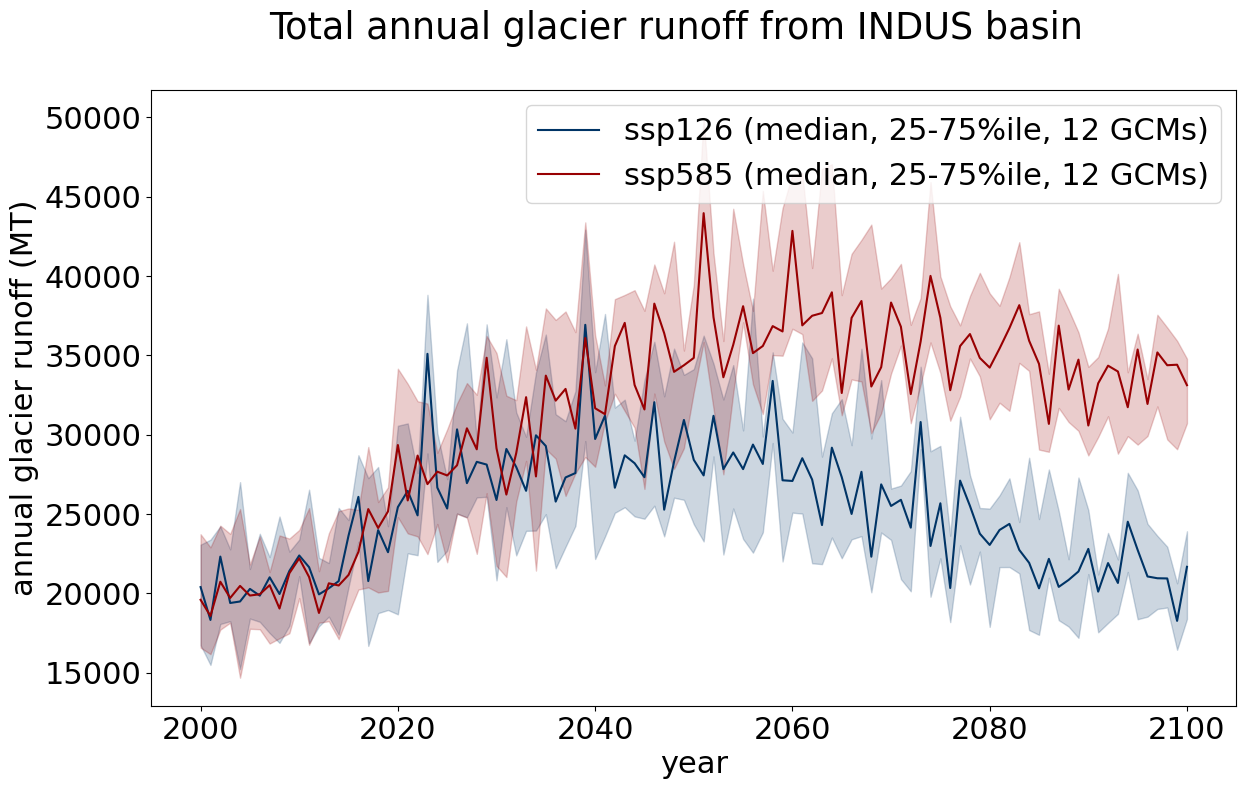

In [25]:
plt.rc('font', size=22)

colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}
fig, ax = plt.subplots(1,1, figsize=(14,8), sharey=True, sharex=True)
for ssp in ['ssp126', 'ssp585']:

    db_rounce = drunoff_basin_rounce_ssp[ssp]/1e9 # kg to Mega Tonnes

    db_rounce_yr_sum = db_rounce.glac_runoff_fixed_monthly.groupby('time.year').sum().sum(dim='rgi_id')
    #db_rounce_yr_sum = db_rounce_yr_sum.sel(year = slice(2020,2099))
    #db_rounce_yr_sum = db_rounce_yr_sum.rolling({'year':3}).mean()

    n_gcm = len(db_rounce_yr_sum.gcm)
    
    sns.lineplot(x='year', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index(),
                 estimator=np.median,ax=ax,errorbar=('pi', 50),
                 ls = '-', label=f'{ssp} (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    #ax.fill_between(db_rounce_yr_sum.year,
    #             db_rounce_yr_sum.quantile(0.25, dim='gcm'),
    #             db_rounce_yr_sum.quantile(0.75, dim='gcm'), alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
    #ax.set_ylim([18000,46000])
    ax.set_xlabel('year')
    ax.set_ylabel(f'annual glacier runoff (MT)')
        
#plt.tight_layout()
plt.suptitle(f'Total annual glacier runoff from {basin} basin')
#plt.savefig(f'annual_glacier_runoff_{basin}.png')
plt.savefig('for_fahad/annual_glacier_runoff_Indus.png')

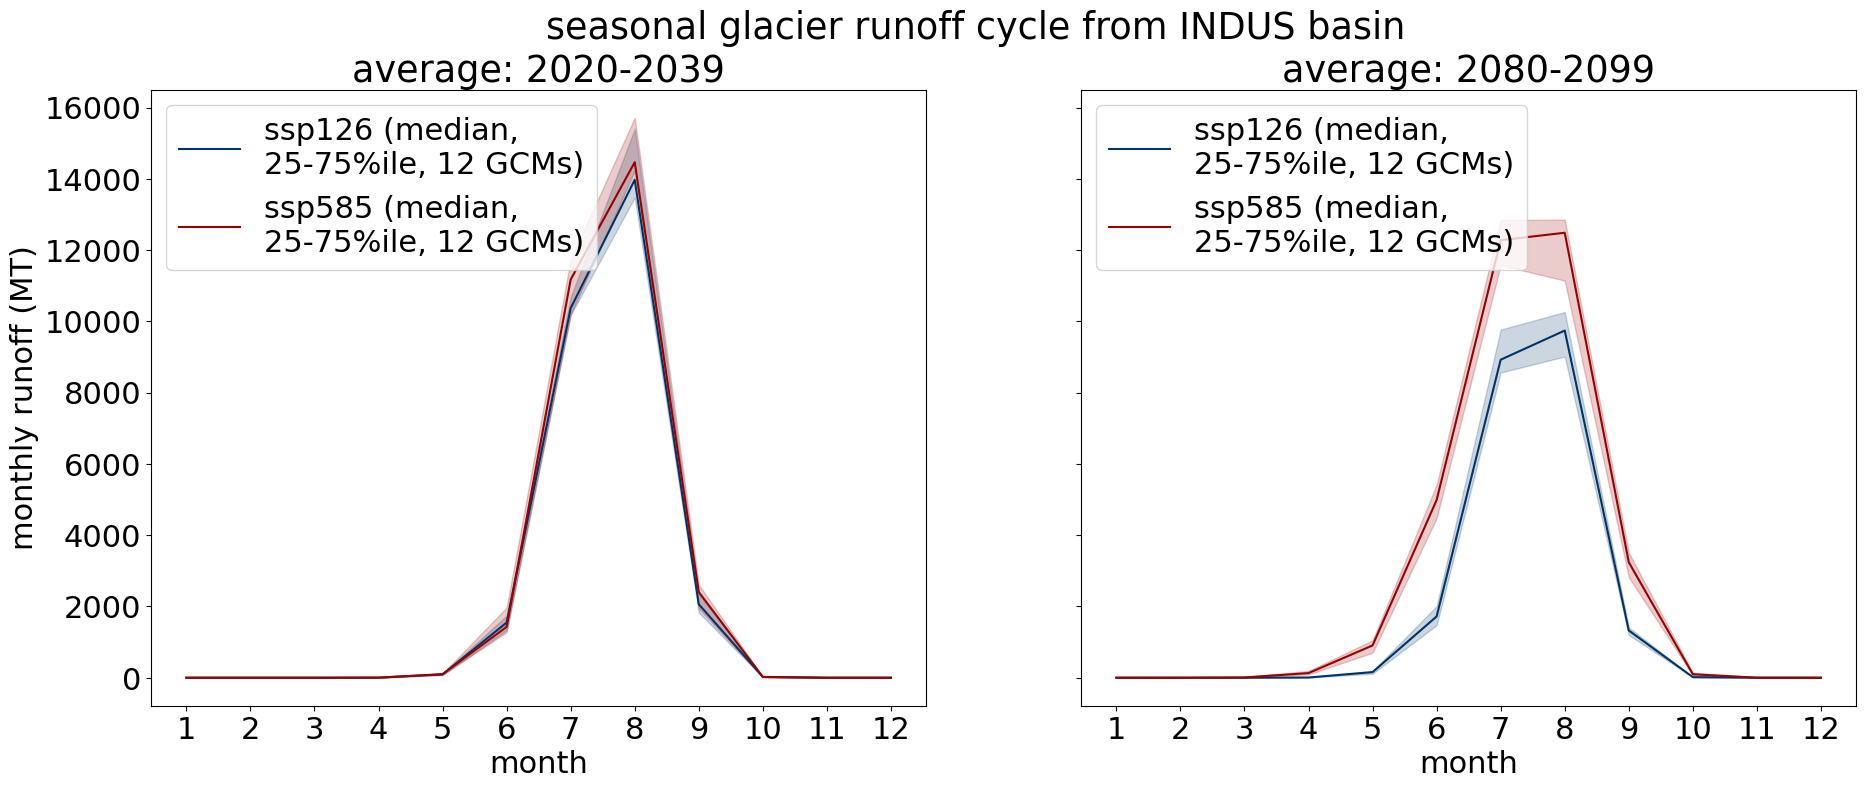

In [24]:
plt.rc('font', size=22)
colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}

fig, axs = plt.subplots(1,2, figsize=(22,8), sharey=True, sharex=True)
for y0,y1 in zip([2020,2080], [2039,2099]):
    if y0 == 2020:
        ax = axs[0]
    else:
        ax = axs[1]
    for ssp in ['ssp126', 'ssp585']:

        db_rounce = drunoff_basin_rounce_ssp[ssp].glac_runoff_fixed_monthly/1e9 # kg to Mega Tonnes

        db_rounce_yr_sum = db_rounce.sel(time=slice(f'{y0}-01-01', f'{y1}-12-01')).sum(dim='rgi_id') #lac_runoff_fixed_monthly.groupby('time.year').sum().sum(dim='rgi_id')

        #db_rounce_yr_sum = db_rounce.sel(time = slice(y0,y1)).sum(dim='rgi_id')
        db_rounce_yr_sum = db_rounce_yr_sum.groupby('time.month').mean()

        ax.set_title(ssp)

        sns.lineplot(x='month', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index(),
                     estimator=np.median,ax=ax,errorbar=('pi',50),
                     ls = '-', label=f'{ssp} (median,\n25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
        ax.set_xticks(np.arange(1,13,1));


        #ax.set_ylim([18000,46000])
        ax.set_xlabel('month')
        ax.set_ylabel(f'monthly runoff (MT)')
    #plt.tight_layout()
    ax.set_title(f'average: {y0}-{y1}')
plt.suptitle(f'seasonal glacier runoff cycle from {basin} basin' )
plt.savefig('for_fahad/sesonal_runoff_cycle_Indus.png')

### Extract monthly runoff from OGGM and save it in a file:

In [78]:
run = False
if run:
    db_s = []
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        db_l = []
        for gcm in gcms:

            db = xr.open_dataset(path_oggm_erik + f'oggm_compiled_{basin_idx}_{gcm}_{ssp}.nc')
            db['runoff'] = db['melt_off_glacier_monthly'] + db['melt_on_glacier_monthly'] + db['liq_prcp_off_glacier_monthly'] + db['liq_prcp_on_glacier_monthly']
            db = db.swap_dims({'month_2d': 'calendar_month_2d'})
            db = db.rename_dims({'time': 'hydro_yr'})
            #db = db.rename_dims({'time': 'hydro_yr'})

            db = db.set_index(hydro_yr = 'time')
            db = db.runoff
            db['gcm'] = gcm
            #db = db.sortby('calendar_month_2d')
            db.attrs['runoff unit'] = 'kg year-1'
            #db=db.sel(hydro_yr=slice(2020,2099))
            db_l.append(db.reset_coords()[['gcm', 'runoff', 'calendar_year']])
        _db_s = xr.concat(db_l, dim='gcm')
        _db_s['ssp'] = ssp
        db_s.append(_db_s)
    db_oggm_erik_ssp = xr.concat(db_s, dim='ssp')
    db_oggm_erik_ssp.to_netcdf(f'runoff_oggm_{basin}_monthly.nc')

In [59]:
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)


array(['ssp126', 'ssp585', 'ssp370', 'ssp534-over', 'ssp245', 'ssp119',
       'ssp434', 'ssp460'], dtype=object)

In [149]:
gcms_cmip6.gcm.unique()
run = False
path_oggm_v16 = '/home/www/lschuster/provide/runoff_example_data/script_run_indus_oggm_v16/output/pure_CMIP6/'
if run:
    db_s = []
    for ssp in gcms_cmip6.ssp.unique():
        db_l = []
        for gcm in gcms_cmip6.gcm.unique():
            try:
                db = xr.open_mfdataset(path_oggm_v16 + f'run_hydro_merged_CMIP6_{gcm}_{ssp}*.nc')
                db['runoff'] = (db['melt_off_glacier_monthly'] + db['melt_on_glacier_monthly'] 
                                + db['liq_prcp_off_glacier_monthly'] + db['liq_prcp_on_glacier_monthly'])
                db = db.swap_dims({'month_2d': 'calendar_month_2d'})
                db = db.rename_dims({'time': 'hydro_yr'})
                #db = db.rename_dims({'time': 'hydro_yr'})

                db = db.set_index(hydro_yr = 'time')
                db = db.runoff
                db['gcm'] = gcm
                #db = db.sortby('calendar_month_2d')
                db.attrs['runoff unit'] = 'kg year-1'
                #db=db.sel(hydro_yr=slice(2020,2099))
                db_l.append(db.reset_coords()[['gcm', 'runoff', 'calendar_year']])
            except:
                pass
        _db_s = xr.concat(db_l, dim='gcm')
        _db_s['ssp'] = ssp
        db_s.append(_db_s)
    db_oggm_v16_ssp = xr.concat(db_s, dim='ssp')
    db_oggm_v16_ssp.to_netcdf(f'runoff_oggm_v16_{basin}_monthly.nc')
    

In [75]:
# also save ref_area
gcms_cmip6.gcm.unique()
run = True
path_oggm_v16 = '/home/www/lschuster/provide/runoff_example_data/script_run_indus_oggm_v16/output/pure_CMIP6/'
if run:
    db_s = []
    for ssp in gcms_cmip6.ssp.unique():
        db_l = []
        for gcm in gcms_cmip6.gcm.unique():
            try:
                with xr.open_mfdataset(path_oggm_v16 + f'run_hydro_merged_CMIP6_{gcm}_{ssp}*.nc') as db:
                    db = db[['off_area', 'on_area']].load()
                #db = db.swap_dims({'month_2d': 'calendar_month_2d'})
                db = db.rename_dims({'time': 'hydro_yr'})
                #db = db.rename_dims({'time': 'hydro_yr'})

                db = db.set_index(hydro_yr = 'time')
                db['ref_area'] = db.off_area + db.on_area
                db = db.ref_area
                db['gcm'] = gcm
                #db = db.sortby('calendar_month_2d')
                #db=db.sel(hydro_yr=slice(2020,2099))
                db_l.append(db.reset_coords()[['gcm', 'ref_area', 'calendar_year']])
            except:
                pass
        _db_s = xr.concat(db_l, dim='gcm')
        _db_s['ssp'] = ssp
        db_s.append(_db_s)
    db_oggm_v16_ssp = xr.concat(db_s, dim='ssp')
    db_oggm_v16_ssp.to_netcdf(f'ref_area_oggm_v16_{basin}_monthly.nc')
    

In [97]:
db_oggm_v16_ssp_ref_area = xr.open_dataset(f'ref_area_oggm_v16_{basin}_monthly.nc').ref_area
db_oggm_v16_ssp_ref_area = db_oggm_v16_ssp_ref_area.dropna(dim='hydro_yr', how='all')
db_oggm_v16_ssp_ref_area_sum = db_oggm_v16_ssp_ref_area.sel(hydro_yr=slice(2000,2100)).sum(dim='rgi_id')#,skipna=True, min_count=len(db_oggm_v16_ssp_ref_area.rgi_id))

In [164]:
dsel_runoff = xr.open_dataset(f'runoff_oggm_v16_{basin}_monthly.nc').sel(ssp='ssp126').isel(gcm=1).sel(hydro_yr=slice(2000,2099))
dsel_runoff = dsel_runoff.runoff.sum(dim='calendar_month_2d').sum(dim='rgi_id')

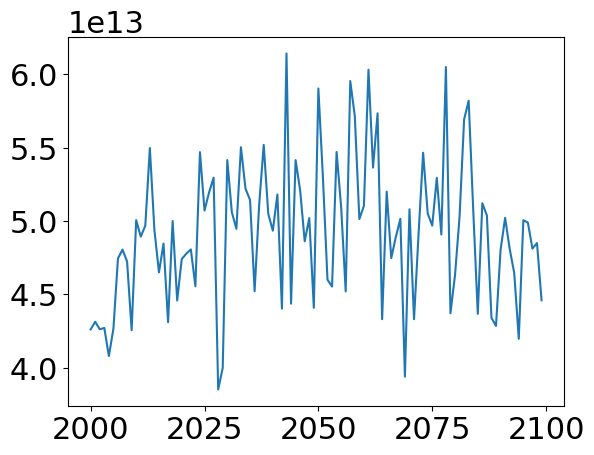

Text(0.5, 1.0, 'R-value: 0.3')

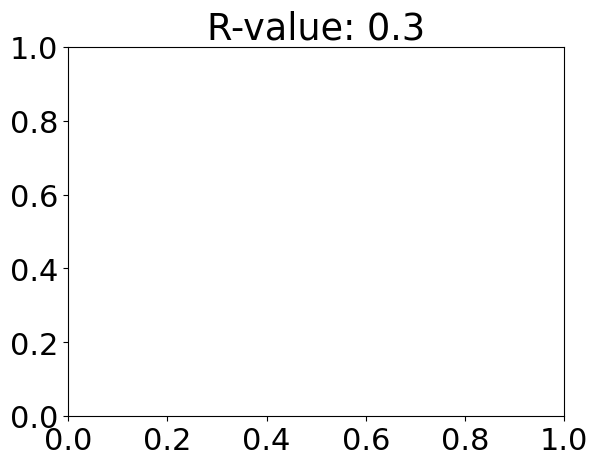

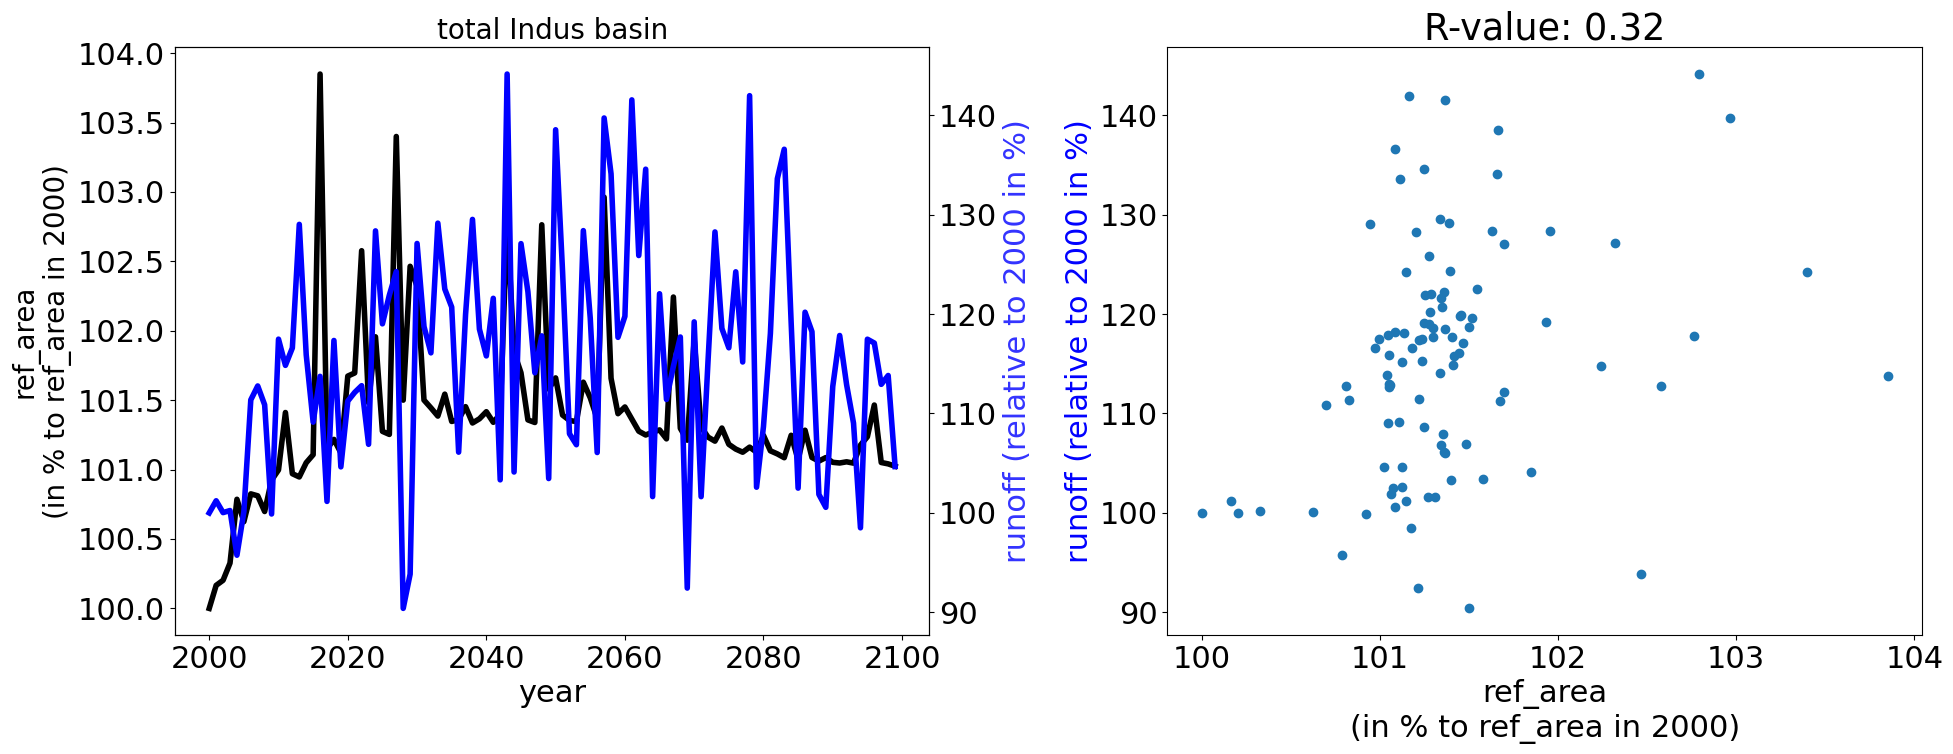

In [199]:
plt.figure(figsize=(20,8))
plt.subplot(121)
dsel = db_oggm_v16_ssp_ref_area_sum.sel(ssp='ssp126').isel(gcm=1).isel(hydro_yr=slice(0,-1))
if np.any(dsel>0):
    plt.plot(dsel.hydro_yr,
             100*dsel/dsel.isel(hydro_yr=0), lw=4, color='black')
plt.ylabel('ref_area\n(in % to ref_area in 2000)', fontsize=20, color='black')
plt.title('total Indus basin', fontsize=20)
#ax.set_ylim([88,220])


plt.xlabel('year')

ax2 = plt.twinx()
ax2.plot(dsel_runoff.hydro_yr, 100*dsel_runoff.values/dsel_runoff.sel(hydro_yr=2000).values,
         color='b',lw=4);
ax2.set_ylabel('runoff (relative to 2000 in %)', color = 'blue', alpha = 0.8)
plt.subplot(122)


plt.ylabel('runoff (relative to 2000 in %)', color='blue')
plt.xlabel('ref_area\n(in % to ref_area in 2000)')

plt.plot(100*dsel/dsel.isel(hydro_yr=0), 100*dsel_runoff.values/dsel_runoff.sel(hydro_yr=2000).values, 'o')
plt.title(f'R-value: {np.corrcoef(100*dsel/dsel.isel(hydro_yr=0), y=100*dsel_runoff.values/dsel_runoff.sel(hydro_yr=2000).values)[0][1]:.2f}')

plt.tight_layout()

Text(0.5, 0, 'year')

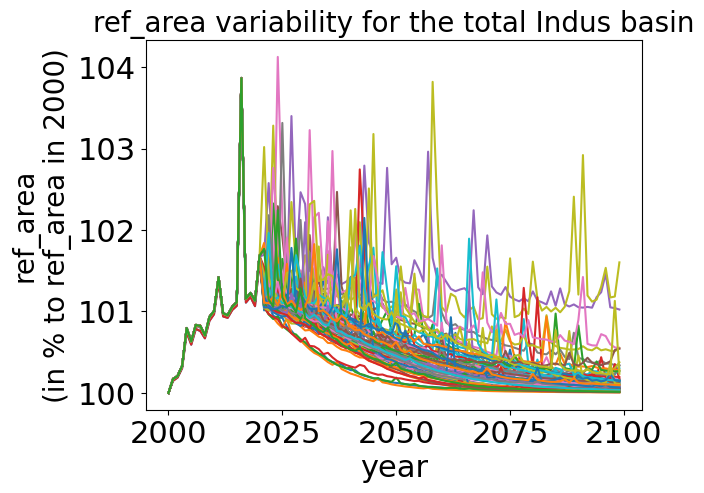

In [133]:
for gcm in db_oggm_v16_ssp_ref_area_sum.gcm:
    for ssp in db_oggm_v16_ssp_ref_area_sum.ssp:
        dsel = db_oggm_v16_ssp_ref_area_sum.sel(ssp=ssp).sel(gcm=gcm).isel(hydro_yr=slice(0,-1))
        if np.any(dsel>0):
            plt.plot(dsel.hydro_yr,
                     100*dsel/dsel.isel(hydro_yr=0))
plt.ylabel('ref_area\n(in % to ref_area in 2000)', fontsize=20)
plt.title('ref_area variability for the total Indus basin', fontsize=20)
plt.xlabel('year')

Text(0, 0.5, 'reference area (yr 2000)')

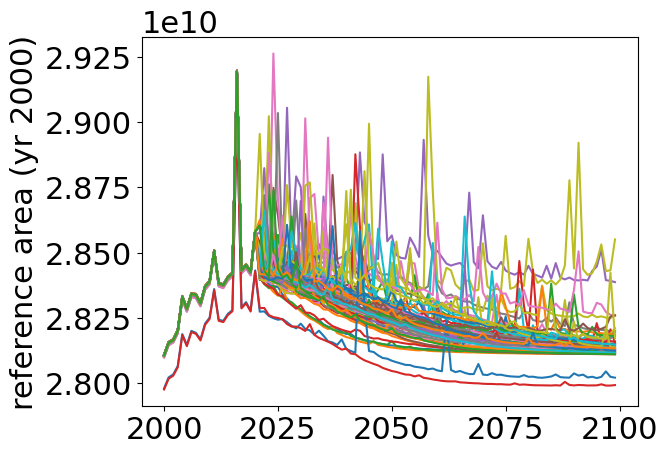

In [123]:
for gcm in db_oggm_v16_ssp_ref_area_sum.gcm:
    for ssp in db_oggm_v16_ssp_ref_area_sum.ssp:
        dsel = db_oggm_v16_ssp_ref_area_sum.sel(ssp=ssp).sel(gcm=gcm).isel(hydro_yr=slice(0,-1))
        if np.any(dsel>0):
            plt.plot(dsel.hydro_yr,
                     dsel)
plt.ylabel('reference area (yr 2000)')

problems:

    - runoff data is in hydrological years -> should I convert it into calendar years (not trivial)

In [79]:
db_oggm_erik_ssp

<xarray.Dataset>
Dimensions:            (gcm: 12, ssp: 4, hydro_yr: 81, calendar_month_2d: 12,
                        rgi_id: 23424)
Coordinates:
  * gcm                (gcm) <U13 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
  * rgi_id             (rgi_id) object 'RGI60-13.00002' ... 'RGI60-14.27988'
  * calendar_month_2d  (calendar_month_2d) int64 10 11 12 1 2 3 4 5 6 7 8 9
  * hydro_yr           (hydro_yr) float64 2.02e+03 2.021e+03 ... 2.1e+03
  * ssp                (ssp) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
Data variables:
    runoff             (ssp, gcm, hydro_yr, calendar_month_2d, rgi_id) float32 ...
    calendar_year      (ssp, gcm, hydro_yr) int64 2019 2020 2021 ... 2098 2099

In [80]:
db_oggm_erik_ssp.hydro_yr

<xarray.DataArray 'hydro_yr' (hydro_yr: 81)>
array([2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027., 2028., 2029.,
       2030., 2031., 2032., 2033., 2034., 2035., 2036., 2037., 2038., 2039.,
       2040., 2041., 2042., 2043., 2044., 2045., 2046., 2047., 2048., 2049.,
       2050., 2051., 2052., 2053., 2054., 2055., 2056., 2057., 2058., 2059.,
       2060., 2061., 2062., 2063., 2064., 2065., 2066., 2067., 2068., 2069.,
       2070., 2071., 2072., 2073., 2074., 2075., 2076., 2077., 2078., 2079.,
       2080., 2081., 2082., 2083., 2084., 2085., 2086., 2087., 2088., 2089.,
       2090., 2091., 2092., 2093., 2094., 2095., 2096., 2097., 2098., 2099.,
       2100.])
Coordinates:
  * hydro_yr  (hydro_yr) float64 2.02e+03 2.021e+03 ... 2.099e+03 2.1e+03

##  Annual runoff comparison

In [8]:
d_working = db_rounce.isel(gcm=-1).sum(dim='time')
d_working.where(d_working!=0).dropna(dim='rgi_id')

NameError: name 'db_rounce' is not defined

In [9]:
dp = xr.open_dataset('/home/www/lschuster/rounce_2023_data/R13_glac_runoff_fixed_monthly_1set_2000_2100-ssp585-Batch-8001-9000.nc').glac_runoff_fixed_monthly
dp = dp.groupby('time.year').sum()
dp.where(dp!=0).dropna(dim='glacier', how='all')

<xarray.DataArray 'glac_runoff_fixed_monthly' (model: 12, glacier: 1000,
                                               year: 101)>
array([[[ 421163.32271247,  428350.40173807,  236180.93655957, ...,
          164672.80833187,  210343.38690611,  204119.75813437],
        [ 419109.9438986 ,  401803.846151  ,  227305.2308056 , ...,
          225963.495927  ,  288746.00352455,  280003.57513188],
        [1200690.21356446, 1207128.29095253,  790434.24852661, ...,
          473402.22337652,  549029.18131243,  541426.94817699],
        ...,
        [ 121973.20055788,  120205.55944412,   81002.05416204, ...,
           55278.35690715,   70767.02924289,   68353.39559877],
        [  82400.64872411,   84388.69332114,   38323.83851968, ...,
           32573.08283819,   40373.74997177,   39766.66193446],
        [  67066.16812958,   67548.62282137,   36004.93468778, ...,
           26318.50433423,   39312.09686865,   31933.47962748]],

       [[ 213474.1875566 ,  214997.28457408,  231778.00170529, ...,
          265009.59288821,  260529.3312875 ,  215212.1645575 ],
        [ 193730.087781  ,  214297.80972054,  209145.56561322, ...,
          361543.00789529,  358550.187143  ,  292168.01165931],
        [ 725963.51284073,  674283.88542866,  799749.54182649, ...,
          664774.87261924,  651967.81120448,  566542.11503985],
...
        [  78493.35010314,   89572.02531429,   90249.46571689, ...,
           81771.61663878,   79838.20242421,  104513.47581776],
        [  52961.3326751 ,   47532.8882202 ,   51224.48943128, ...,
           48771.53509895,   48084.24070128,   62045.04366603],
        [  41497.63177282,   38071.0126381 ,   42226.37690294, ...,
           37999.50941189,   37055.06549567,   48234.05358955]],

       [[ 341047.03013004,  224381.56446911,  354442.55627237, ...,
          219126.70681384,  205052.48392779,  240545.31214457],
        [ 324855.09983937,  207129.25432627,  338909.65640149, ...,
          306119.02967775,  286513.31353742,  334019.27335634],
        [1013776.03184228,  749739.00684619, 1036305.16864216, ...,
          574357.88998442,  547773.83981725,  605663.16537171],
        ...,
        [ 104880.11344552,   75876.54268797,  104281.58117388, ...,
           77793.34227983,   72341.02392792,   75983.74595444],
        [  61314.32660297,   35710.38808346,   69694.06590394, ...,
           44416.68380562,   41258.23942087,   43469.92784485],
        [  52424.6549027 ,   33725.50944504,   54220.19118793, ...,
           37468.24987823,   34848.12606489,   36624.65171225]]])
Coordinates:
    RGIId          (glacier) object 'RGI60-13.08001' ... 'RGI60-13.09000'
    Climate_Model  (model) object 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
    lon            (glacier) float64 77.53 77.52 77.49 ... 77.08 77.07 77.06
    lat            (glacier) float64 41.81 41.81 41.92 ... 41.84 41.85 41.84
  * year           (year) int64 2000 2001 2002 2003 2004 ... 2097 2098 2099 2100
Dimensions without coordinates: model, glacier

In [101]:
dp

<xarray.DataArray 'glac_runoff_fixed_monthly' (model: 12, glacier: 1000,
                                               time: 1212)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
    RGIId          (glacier) object 'RGI60-13.08001' ... 'RGI60-13.09000'
    Climate_Model  (model) object 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
    lon            (glacier) float64 77.53 77.52 77.49 ... 77.08 77.07 77.06
    lat            (glacier) float64 41.81 41.81 41.92 ... 41.84 41.85 41.84
  * time           (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2100-12-01
Dimensions without coordinates: model, glacier
Attributes:
    long_name:            Glacier-wide runoff
    unit:                 m3
    temporal_resolution:  monthly
    comment:              runoff from a fixed-gauge at glacier terminus that ...
    grid_mapping:         crs

In [81]:
db.runoff.dropna(dim='rgi_id', how= 'all')

<xarray.DataArray 'runoff' (time: 100, rgi_id: 23390)>
array([[8.3875504e+07, 7.9531110e+08, 2.0042262e+08, ..., 2.8898712e+07,
        6.0809712e+07, 3.8973804e+07],
       [9.6166120e+07, 8.8865837e+08, 1.7704848e+08, ..., 2.8444002e+07,
        6.9275264e+07, 3.6920380e+07],
       [1.8680954e+08, 9.2112640e+08, 2.2733728e+08, ..., 3.5258640e+07,
        8.4173264e+07, 4.8226992e+07],
       ...,
       [3.2251334e+08, 1.2122401e+09, 2.4285963e+08, ..., 2.3531648e+07,
        6.1522008e+07, 2.8962562e+07],
       [3.3573936e+08, 2.0365238e+09, 4.3380963e+08, ..., 6.3017200e+07,
        1.6475448e+08, 7.7561056e+07],
       [2.2699155e+08, 1.0146522e+09, 2.0557677e+08, ..., 2.1397358e+07,
        5.5942040e+07, 2.6335692e+07]], dtype=float32)
Coordinates:
  * time            (time) float64 2e+03 2.001e+03 ... 2.098e+03 2.099e+03
  * rgi_id          (rgi_id) object 'RGI60-13.00002' ... 'RGI60-14.27988'
    hydro_year      (time) int64 2000 2001 2002 2003 ... 2096 2097 2098 2099
    hydro_month     (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 2000 2001 2002 2003 ... 2096 2097 2098 2099
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

In [126]:
gcm

'NorESM2-MM'

In [125]:
ssp = '126'

'ssp585'

/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/users/lschuster/.local/lib/python3

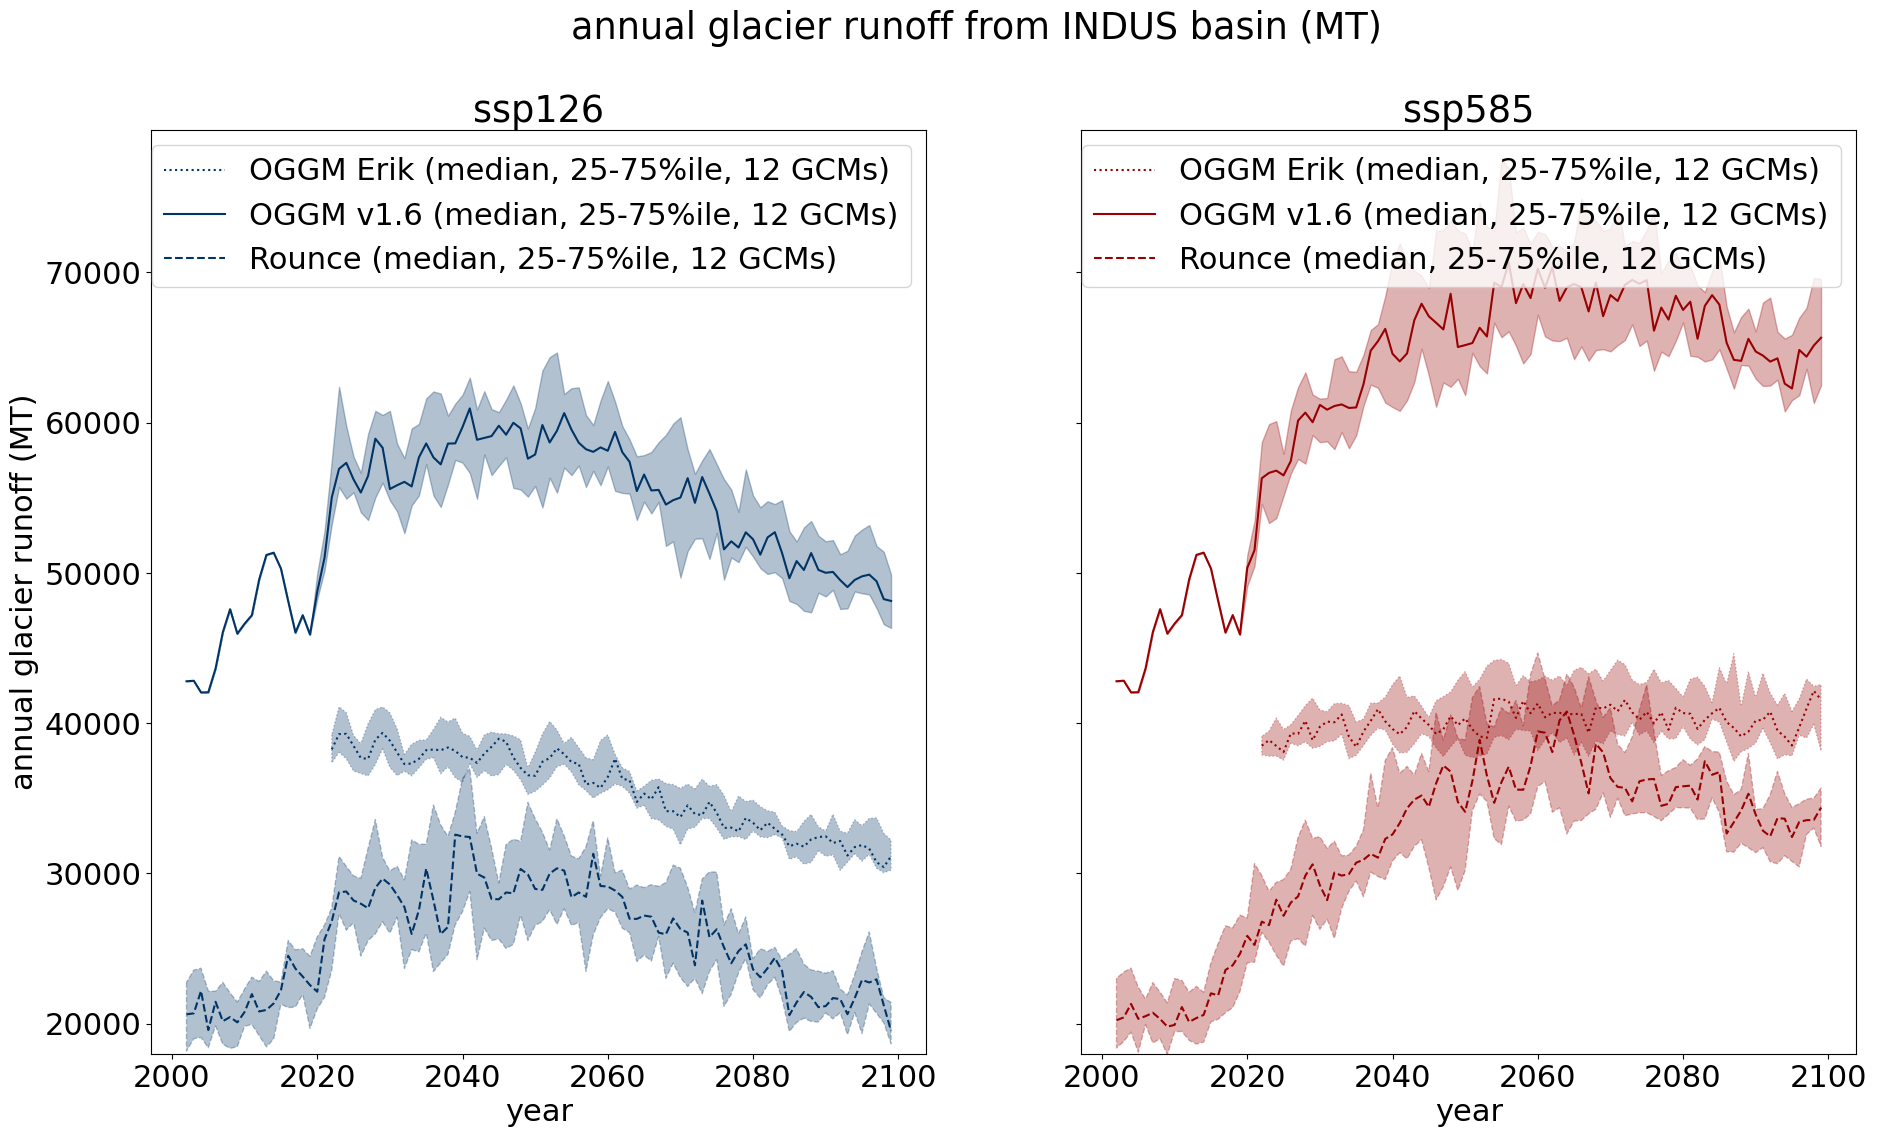

In [54]:
plt.rc('font', size=22)

colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}
fig, axs = plt.subplots(1,2, figsize=(22,12), sharey=True, sharex=True)
for ssp in ['ssp126', 'ssp585']:
    
    _db_l = []
    _db_gcm_l = []
    #for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    for gcm in gcms:
        # this is the file with data for every single glacier 
        db = xr.open_dataset(path_oggm_erik + f'oggm_compiled_{basin_idx}_{gcm}_{ssp}.nc')
        db['runoff'] = db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier']
        db['gcm'] = gcm
        db = db.sel(time = slice(2000,2099))
        db = db[['runoff', 'gcm']]
        _db_l.append(db)
    db_oggm_erik_ssp = xr.concat(_db_l, dim='gcm')
    db_oggm_erik_ssp = db_oggm_erik_ssp.runoff/1e9 # kg to  Mega Tonnes
    
    path_oggm_v16 = '/home/www/lschuster/provide/runoff_example_data/script_run_indus_oggm_v16/output/pure_CMIP6/'
    _db_l = []
    _db_gcm_l = []
    for gcm in gcms:
        # this is the file with data for every single glacier 
        with  xr.open_mfdataset(path_oggm_v16 +f'run_hydro_merged_CMIP6_{gcm}_{ssp}*.nc') as db:
            db['runoff'] = db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier']
            db['gcm'] = gcm
            db = db.sel(time = slice(2000,2099))
            db = db[['runoff', 'gcm']].load()
        _db_l.append(db)
    db_oggm_v16_ssp = xr.concat(_db_l, dim='gcm')
    db_oggm_v16_ssp = db_oggm_v16_ssp.runoff/1e9 # kg to  Mega Tonnes
    
    
    #db_oggm_erik_ssp_sum = db_oggm_erik_ssp.groupby('time.year').sum()

    db_rounce = xr.open_dataset(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc').glac_runoff_fixed_monthly/1e9 # kg to Mega Tonnes

    db_rounce_yr_sum = db_rounce.groupby('time.year').sum().sum(dim='rgi_id')
    db_rounce_yr_sum = db_rounce_yr_sum.sel(year = slice(2000,2099))

    db_rounce_yr_sum = db_rounce_yr_sum.rolling({'year':3}).mean()

    db_oggm_erik_ssp = db_oggm_erik_ssp.sel(rgi_id=db_rounce.rgi_id.values).sum(dim='rgi_id')
    db_oggm_erik_ssp = db_oggm_erik_ssp.sel(time = slice(2000,2099))
    db_oggm_erik_ssp = db_oggm_erik_ssp.rolling({'time':3}).mean()
    n_gcm = len(db_oggm_erik_ssp.gcm)
    
    db_oggm_v16_ssp = db_oggm_v16_ssp.sel(rgi_id=db_rounce.rgi_id.values).sum(dim='rgi_id')
    db_oggm_v16_ssp = db_oggm_v16_ssp.sel(time = slice(2000,2099))
    db_oggm_v16_ssp = db_oggm_v16_ssp.rolling({'time':3}).mean()
    n_gcm_oggm_v16 = len(db_oggm_v16_ssp.gcm)


    if ssp == 'ssp126':
        ax = axs[0]
    else:
        ax = axs[1]
    
    ax.set_title(ssp)
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_erik_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = ':', label=f'OGGM Erik (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_oggm_erik_ssp.time,
                 db_oggm_erik_ssp.quantile(0.25, dim='gcm', skipna=True),
                 db_oggm_erik_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = ':',color = colors_dict[ssp])
    
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_v16_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = '-', label=f'OGGM v1.6 (median, 25-75%ile, {n_gcm_oggm_v16} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_oggm_v16_ssp.time,
                 db_oggm_v16_ssp.quantile(0.25, dim='gcm', skipna=True),
                 db_oggm_v16_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '-',color = colors_dict[ssp])
    
    sns.lineplot(x='year', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median,ax=ax,errorbar=None,
                 ls = '--', label=f'Rounce (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_rounce_yr_sum.year,
                 db_rounce_yr_sum.quantile(0.25, dim='gcm', skipna=True),
                 db_rounce_yr_sum.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
    ax.set_ylim([18000,79500])
    ax.set_xlabel('year')
    if ssp == 'ssp126':
        ax.set_ylabel(f'annual glacier runoff (MT)')
    else:
        ax.set_ylabel('')
        
    assert np.all(db_rounce_yr_sum.gcm == db_oggm_erik_ssp.gcm)
#plt.tight_layout()
plt.suptitle(f'annual glacier runoff from {basin} basin (MT)')
plt.savefig(f'annual_glacier_runoff_{basin}.png')

In [15]:
db_rounce_yr_sum

<xarray.DataArray 'glac_runoff_fixed_monthly' (gcm: 12, year: 100)>
array([[        nan,         nan, 99.09062826, ..., 72.96119266,
        68.96954099, 67.13733133],
       [        nan,         nan, 66.94200875, ..., 73.40398869,
        63.21606232, 63.04132331],
       [        nan,         nan, 93.13540184, ..., 76.23517047,
        80.52481986, 74.00299028],
       ...,
       [        nan,         nan, 82.23918759, ..., 79.42487775,
        74.59565253, 78.97827646],
       [        nan,         nan, 97.7674347 , ..., 56.78967033,
        61.22004234, 60.59642815],
       [        nan,         nan, 96.74293681, ..., 80.33039862,
        76.02856694, 70.22836774]])
Coordinates:
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      object ...
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2095 2096 2097 2098 2099

In [26]:
db_rounce

<xarray.DataArray 'glac_runoff_fixed_monthly' (gcm: 12, rgi_id: 23422,
                                               time: 1212)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2100-12-01
  * rgi_id   (rgi_id) object 'RGI60-13.52348' ... 'RGI60-14.00116'
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      object ...

ValueError: 'y1' is not 1-dimensional

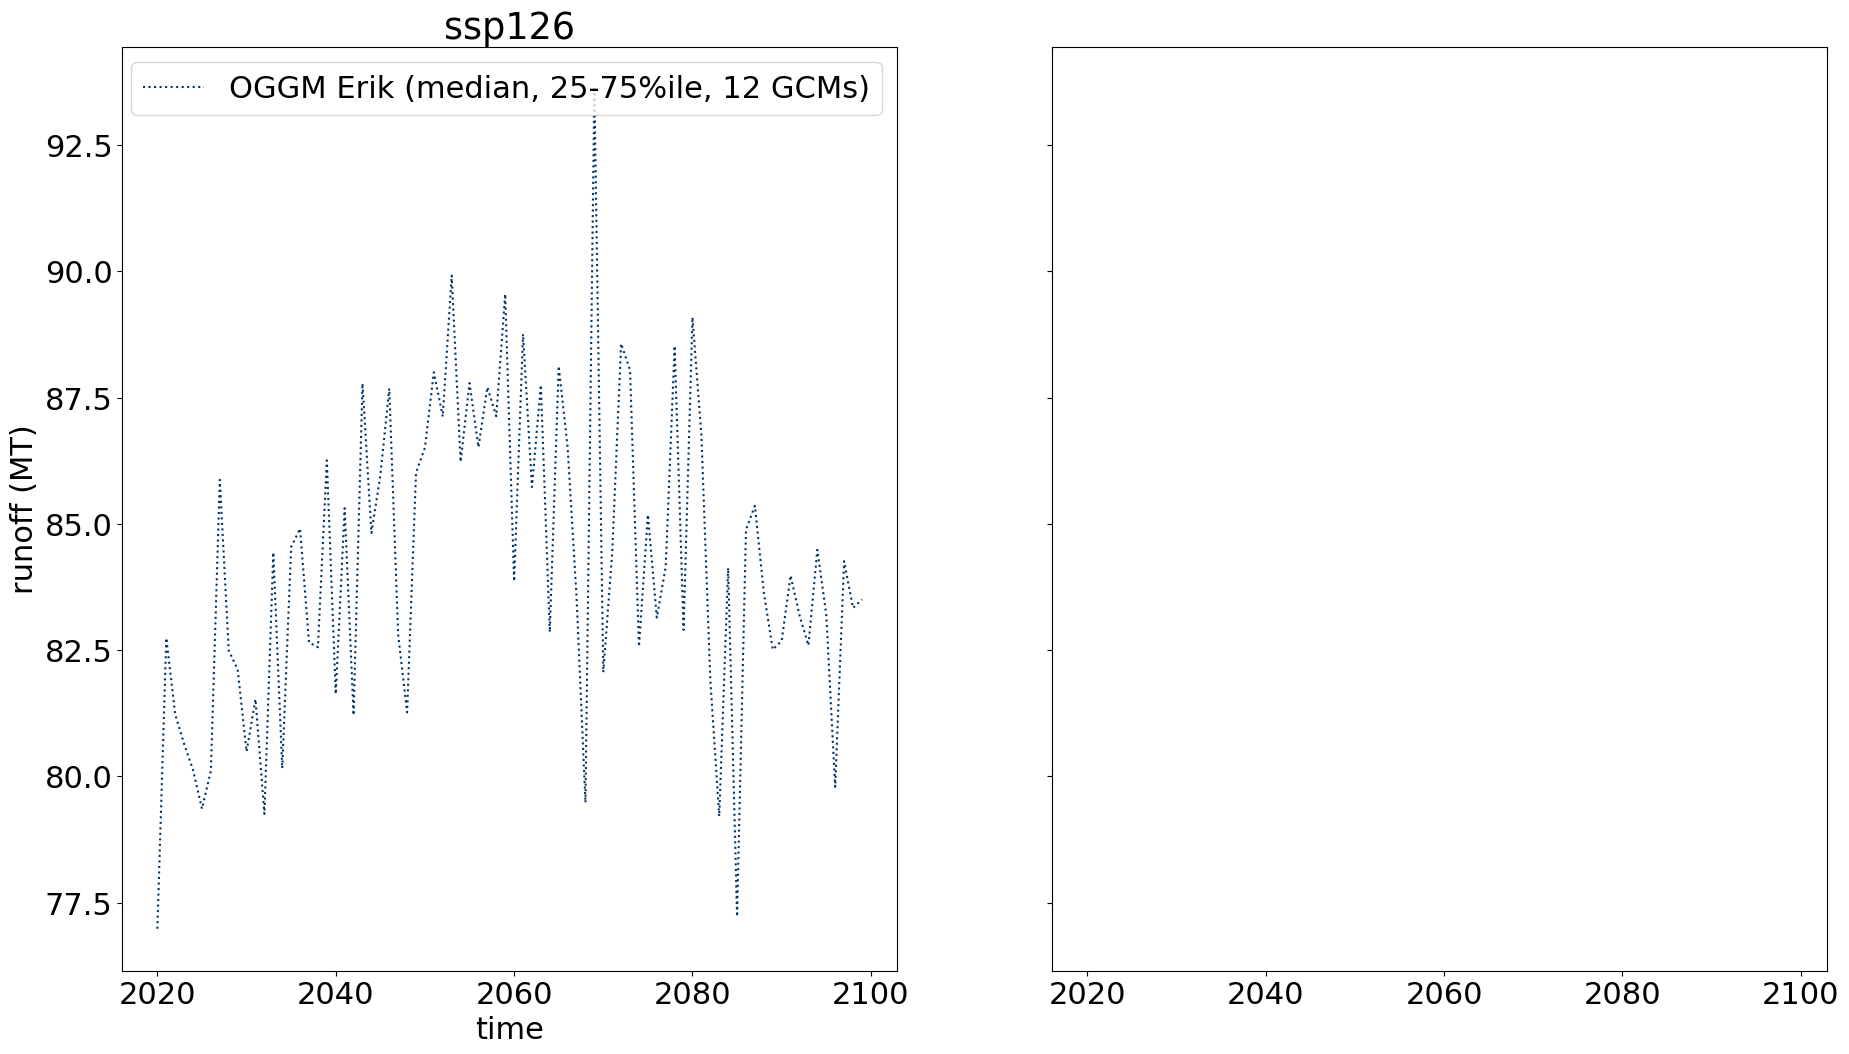

In [44]:
sel_glac = 'RGI60-14.20157'
plt.rc('font', size=22)

colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}
fig, axs = plt.subplots(1,2, figsize=(22,12), sharey=True, sharex=True)
for ssp in ['ssp126', 'ssp585']:
    
    _db_l = []
    _db_gcm_l = []
    #for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    for gcm in gcms:
        # this is the file with data for every single glacier 
        db = xr.open_dataset(path_oggm_erik + f'oggm_compiled_{basin_idx}_{gcm}_{ssp}.nc')
        db=db.sel(rgi_id=[sel_glac])
        db['runoff'] = db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier']
        db['gcm'] = gcm
        db = db.sel(time = slice(2000,2099))
        db = db[['runoff', 'gcm']]
        _db_l.append(db)
    db_oggm_erik_ssp = xr.concat(_db_l, dim='gcm')
    db_oggm_erik_ssp = db_oggm_erik_ssp.runoff/1e9 # kg to  Mega Tonnes
    
    path_oggm_v16 = '/home/www/lschuster/provide/runoff_example_data/script_run_indus_oggm_v16/output/pure_CMIP6/'
    _db_l = []
    _db_gcm_l = []
    for gcm in gcms:
        # this is the file with data for every single glacier 
        with  xr.open_mfdataset(path_oggm_v16 +f'run_hydro_merged_CMIP6_{gcm}_{ssp}*.nc') as db:
            db['runoff'] = db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier']
            db['gcm'] = gcm
            db=db.sel(rgi_id=[sel_glac])
            db = db.sel(time = slice(2000,2099))
            db = db[['runoff', 'gcm']].load()
        _db_l.append(db)
    db_oggm_v16_ssp = xr.concat(_db_l, dim='gcm')
    db_oggm_v16_ssp = db_oggm_v16_ssp.runoff/1e9 # kg to  Mega Tonnes
    
    
    #db_oggm_erik_ssp_sum = db_oggm_erik_ssp.groupby('time.year').sum()

    db_rounce = xr.open_dataset(f'for_fahad/runoff_rounce_{basin}_{ssp}_monthly.nc').glac_runoff_fixed_monthly/1e9 # kg to Mega Tonnes

    db_rounce_yr_sum = db_rounce.sel(rgi_id=[sel_glac]).groupby('time.year').sum().sum(dim='rgi_id')
    db_rounce_yr_sum = db_rounce_yr_sum.sel(year = slice(2000,2099))

    #db_rounce_yr_sum = db_rounce_yr_sum.rolling({'year':3}).mean()

    #db_oggm_erik_ssp = db_oggm_erik_ssp.sum(dim='rgi_id')
    db_oggm_erik_ssp = db_oggm_erik_ssp.sel(time = slice(2000,2099))
    #db_oggm_erik_ssp = db_oggm_erik_ssp.rolling({'time':3}).mean()
    n_gcm = len(db_oggm_erik_ssp.gcm)
    
    #db_oggm_v16_ssp = db_oggm_v16_ssp.sum(dim='rgi_id')
    db_oggm_v16_ssp = db_oggm_v16_ssp.sel(time = slice(2000,2099))
    #db_oggm_v16_ssp = db_oggm_v16_ssp.rolling({'time':3}).mean()
    n_gcm_oggm_v16 = len(db_oggm_v16_ssp.gcm)


    if ssp == 'ssp126':
        ax = axs[0]
    else:
        ax = axs[1]
    
    ax.set_title(ssp)
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_erik_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = ':', label=f'OGGM Erik (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_oggm_erik_ssp.time,
                 db_oggm_erik_ssp.quantile(0.25, dim='gcm', skipna=True),
                 db_oggm_erik_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = ':',color = colors_dict[ssp])
    
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_v16_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = '-', label=f'OGGM v1.6 (median, 25-75%ile, {n_gcm_oggm_v16} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_oggm_v16_ssp.time,
                 db_oggm_v16_ssp.quantile(0.25, dim='gcm', skipna=True),
                 db_oggm_v16_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '-',color = colors_dict[ssp])
    
    sns.lineplot(x='year', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median,ax=ax,errorbar=None,
                 ls = '--', label=f'Rounce (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    ax.fill_between(db_rounce_yr_sum.year,
                 db_rounce_yr_sum.quantile(0.25, dim='gcm', skipna=True),
                 db_rounce_yr_sum.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
    ax.set_ylim([18000,79500])
    ax.set_xlabel('year')
    if ssp == 'ssp126':
        ax.set_ylabel(f'annual glacier runoff (MT)')
    else:
        ax.set_ylabel('')
        
    assert np.all(db_rounce_yr_sum.gcm == db_oggm_erik_ssp.gcm)
plt.suptitle(f'annual glacier runoff from {sel_glac} (MT)')


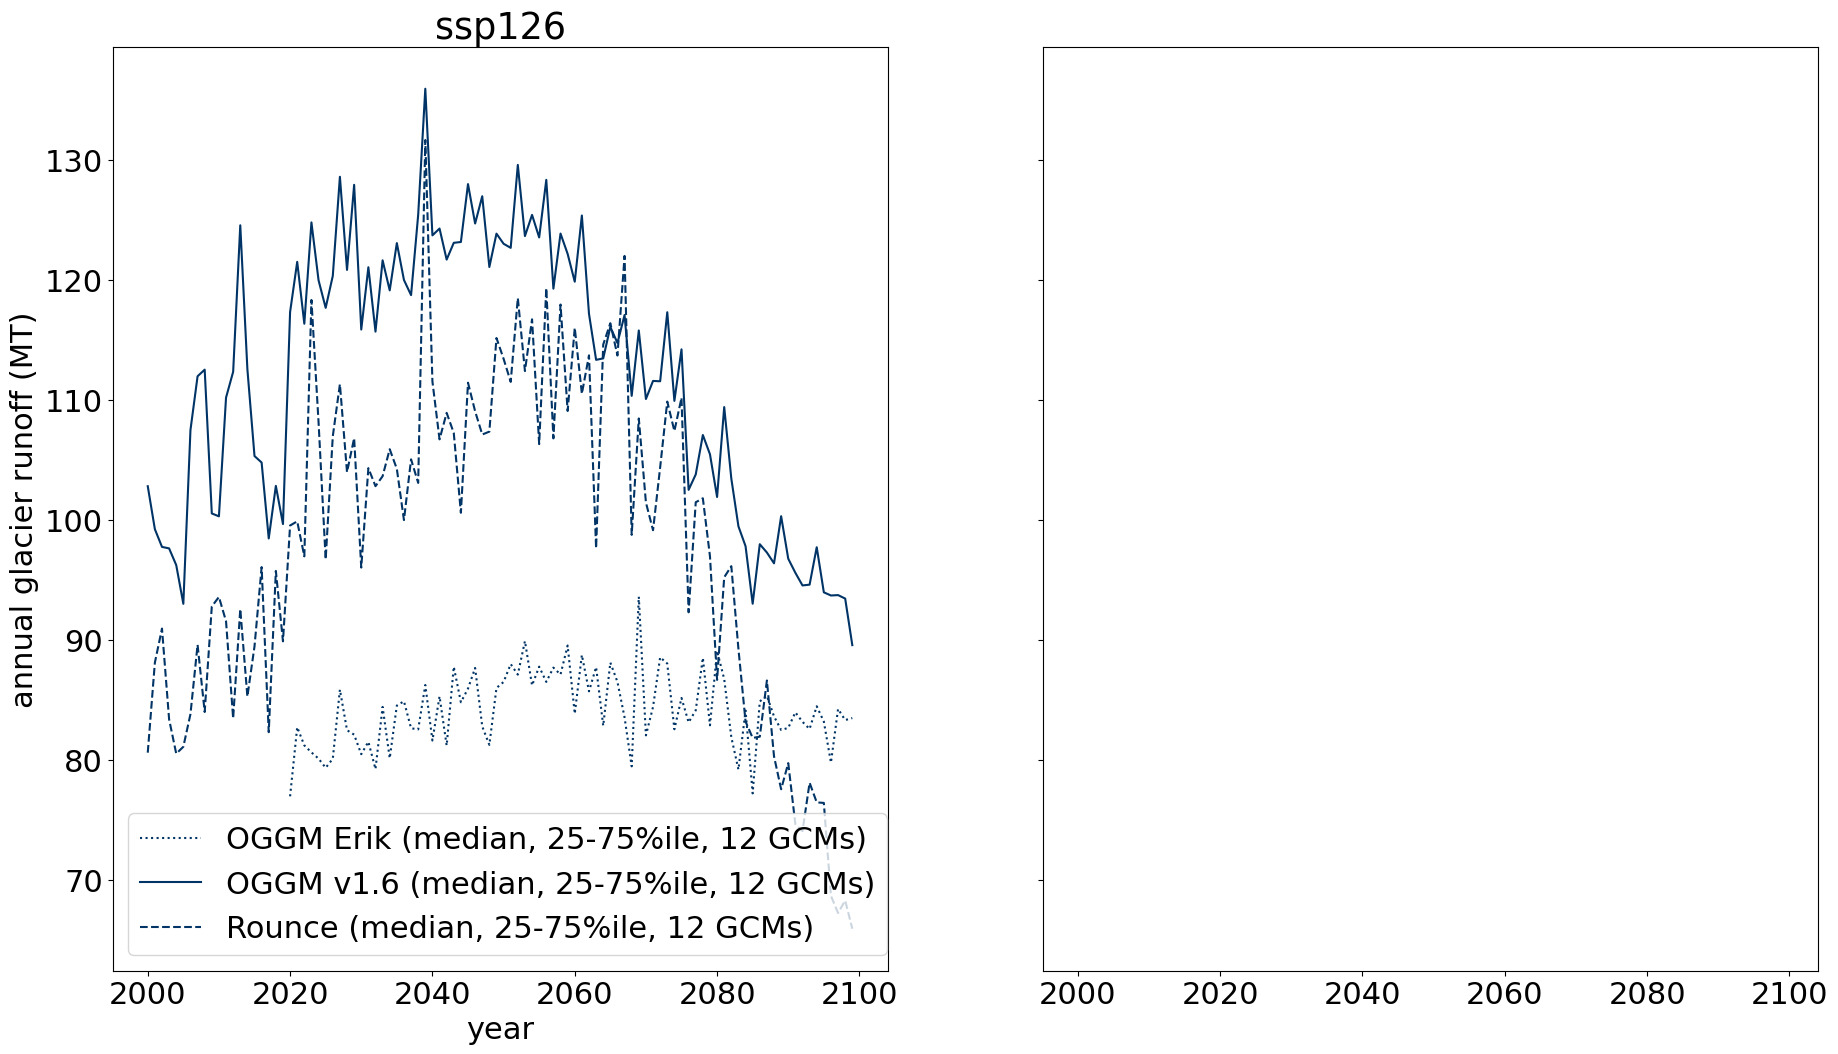

In [46]:
    fig, axs = plt.subplots(1,2, figsize=(22,12), sharey=True, sharex=True)

    db_rounce_yr_sum = db_rounce.sel(rgi_id=[sel_glac]).groupby('time.year').sum().sum(dim='rgi_id')
    db_rounce_yr_sum = db_rounce_yr_sum.sel(year = slice(2000,2099))

    #db_rounce_yr_sum = db_rounce_yr_sum.rolling({'year':3}).mean()

    #db_oggm_erik_ssp = db_oggm_erik_ssp.sum(dim='rgi_id')
    db_oggm_erik_ssp = db_oggm_erik_ssp.sel(time = slice(2000,2099))
    #db_oggm_erik_ssp = db_oggm_erik_ssp.rolling({'time':3}).mean()
    n_gcm = len(db_oggm_erik_ssp.gcm)
    
    #db_oggm_v16_ssp = db_oggm_v16_ssp.sum(dim='rgi_id')
    db_oggm_v16_ssp = db_oggm_v16_ssp.sel(time = slice(2000,2099))
    #db_oggm_v16_ssp = db_oggm_v16_ssp.rolling({'time':3}).mean()
    n_gcm_oggm_v16 = len(db_oggm_v16_ssp.gcm)


    if ssp == 'ssp126':
        ax = axs[0]
    else:
        ax = axs[1]
    
    ax.set_title(ssp)
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_erik_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = ':', label=f'OGGM Erik (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
   # ax.fill_between(db_oggm_erik_ssp.time,
   #              db_oggm_erik_ssp.quantile(0.25, dim='gcm', skipna=True),
   #              db_oggm_erik_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = ':',color = colors_dict[ssp])
    
    sns.lineplot(x='time', y='runoff (MT)', data=db_oggm_v16_ssp.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median, ax=ax,errorbar=None,
                 ls = '-', label=f'OGGM v1.6 (median, 25-75%ile, {n_gcm_oggm_v16} GCMs)', color = colors_dict[ssp])
    #ax.fill_between(db_oggm_v16_ssp.time,
    #             db_oggm_v16_ssp.quantile(0.25, dim='gcm', skipna=True),
    #             db_oggm_v16_ssp.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '-',color = colors_dict[ssp])
    
    sns.lineplot(x='year', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index().dropna(),
                 estimator=np.median,ax=ax,errorbar=None,
                 ls = '--', label=f'Rounce (median, 25-75%ile, {n_gcm} GCMs)', color = colors_dict[ssp])
    #ax.fill_between(db_rounce_yr_sum.year,
    #             db_rounce_yr_sum.quantile(0.25, dim='gcm', skipna=True),
    #             db_rounce_yr_sum.quantile(0.75, dim='gcm', skipna=True), alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
    #ax.set_ylim([18000,79500])
    ax.set_xlabel('year')
    if ssp == 'ssp126':
        ax.set_ylabel(f'annual glacier runoff (MT)')
    else:
        ax.set_ylabel('')
        
    assert np.all(db_rounce_yr_sum.gcm == db_oggm_erik_ssp.gcm)

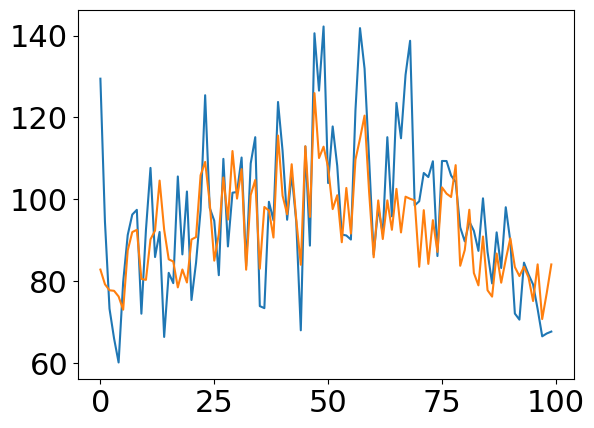

In [47]:
plt.plot(db_rounce_yr_sum.isel(gcm=0))
plt.plot(db_oggm_v16_ssp.isel(gcm=0)-20)

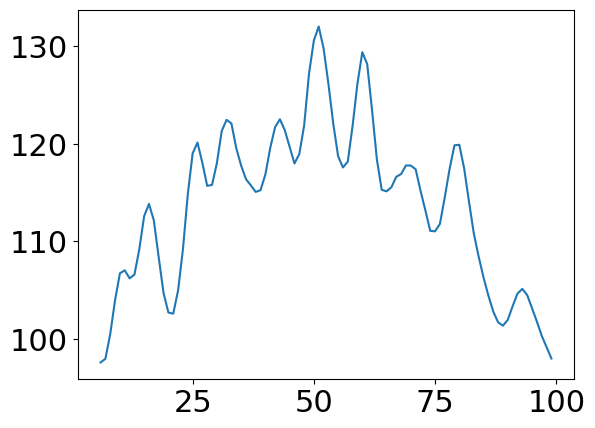

In [20]:
import oggm

In [25]:
oggm.core.flowline.run_with_hydro?

Signature:
oggm.core.flowline.run_with_hydro(
    gdir,
    run_task=None,
    store_monthly_hydro=False,
    fixed_geometry_spinup_yr=None,
    ref_area_from_y0=False,
    ref_area_yr=None,
    ref_geometry_filesuffix=None,
    **kwargs,
)
Docstring:
Run the flowline model and add hydro diagnostics.

TODOs:
    - Add the possibility to record MB during run to improve performance
      (requires change in API)
    - ...

Parameters
----------
run_task : func
    any of the `run_*`` tasks in the oggm.flowline module.
    The mass balance model used needs to have the `add_climate` output
    kwarg available though.
store_monthly_hydro : bool
    also compute monthly hydrological diagnostics. The monthly outputs
    are stored in 2D fields (years, months)
ref_area_yr : int
    the hydrological output is computed over a reference area, which
    per default is the largest area covered by the glacier in the simulation
    period. Use this kwarg to force a specific area to the state of the
 

In [77]:
db_rounce.where(db_rounce.isel(time=0)!=0).dropna(dim='rgi_id', how='all')

<xarray.DataArray 'glac_runoff_fixed_monthly' (gcm: 12, rgi_id: 0, time: 1212)>
array([], shape=(12, 0, 1212), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2100-12-01
  * rgi_id   (rgi_id) object 
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      <U6 'ssp585'

In [70]:
db_rounce.where(db_rounce!=0).dropna(dim='rgi_id', how='all')

<xarray.DataArray 'glac_runoff_fixed_monthly' (gcm: 12, rgi_id: 23422,
                                               time: 1212)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2100-12-01
  * rgi_id   (rgi_id) object 'RGI60-13.52348' ... 'RGI60-14.00116'
  * gcm      (gcm) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-MM'
    ssp      <U6 'ssp585'

In [65]:
db_rounce.glac_runoff_fixed_monthly

AttributeError: 'DataArray' object has no attribute 'glac_runoff_fixed_monthly'

### Monthly runoff

In [234]:
db = xr.open_dataset(path_oggm_erik + f'oggm_compiled_{basin_idx}_{gcm}_{ssp}.nc')
db = db.sel(time = slice(y0,y1))

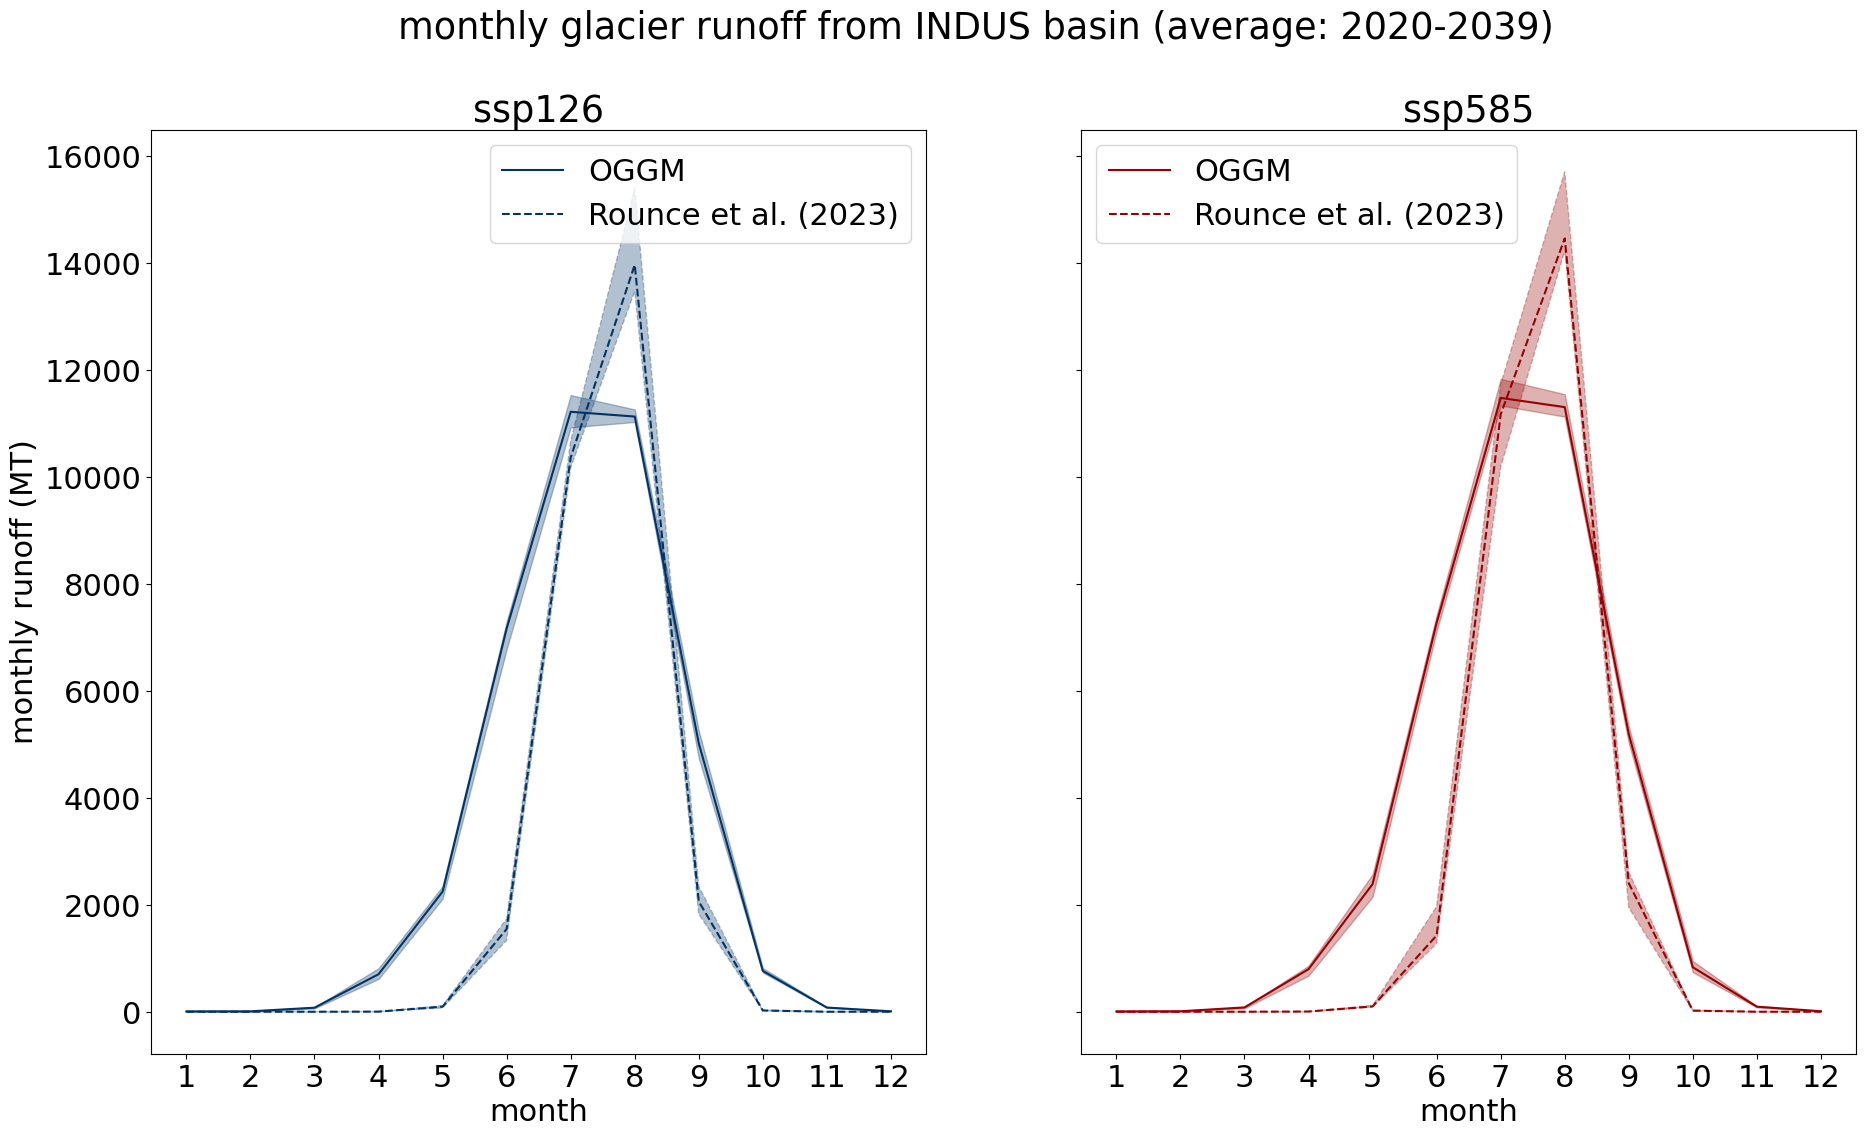

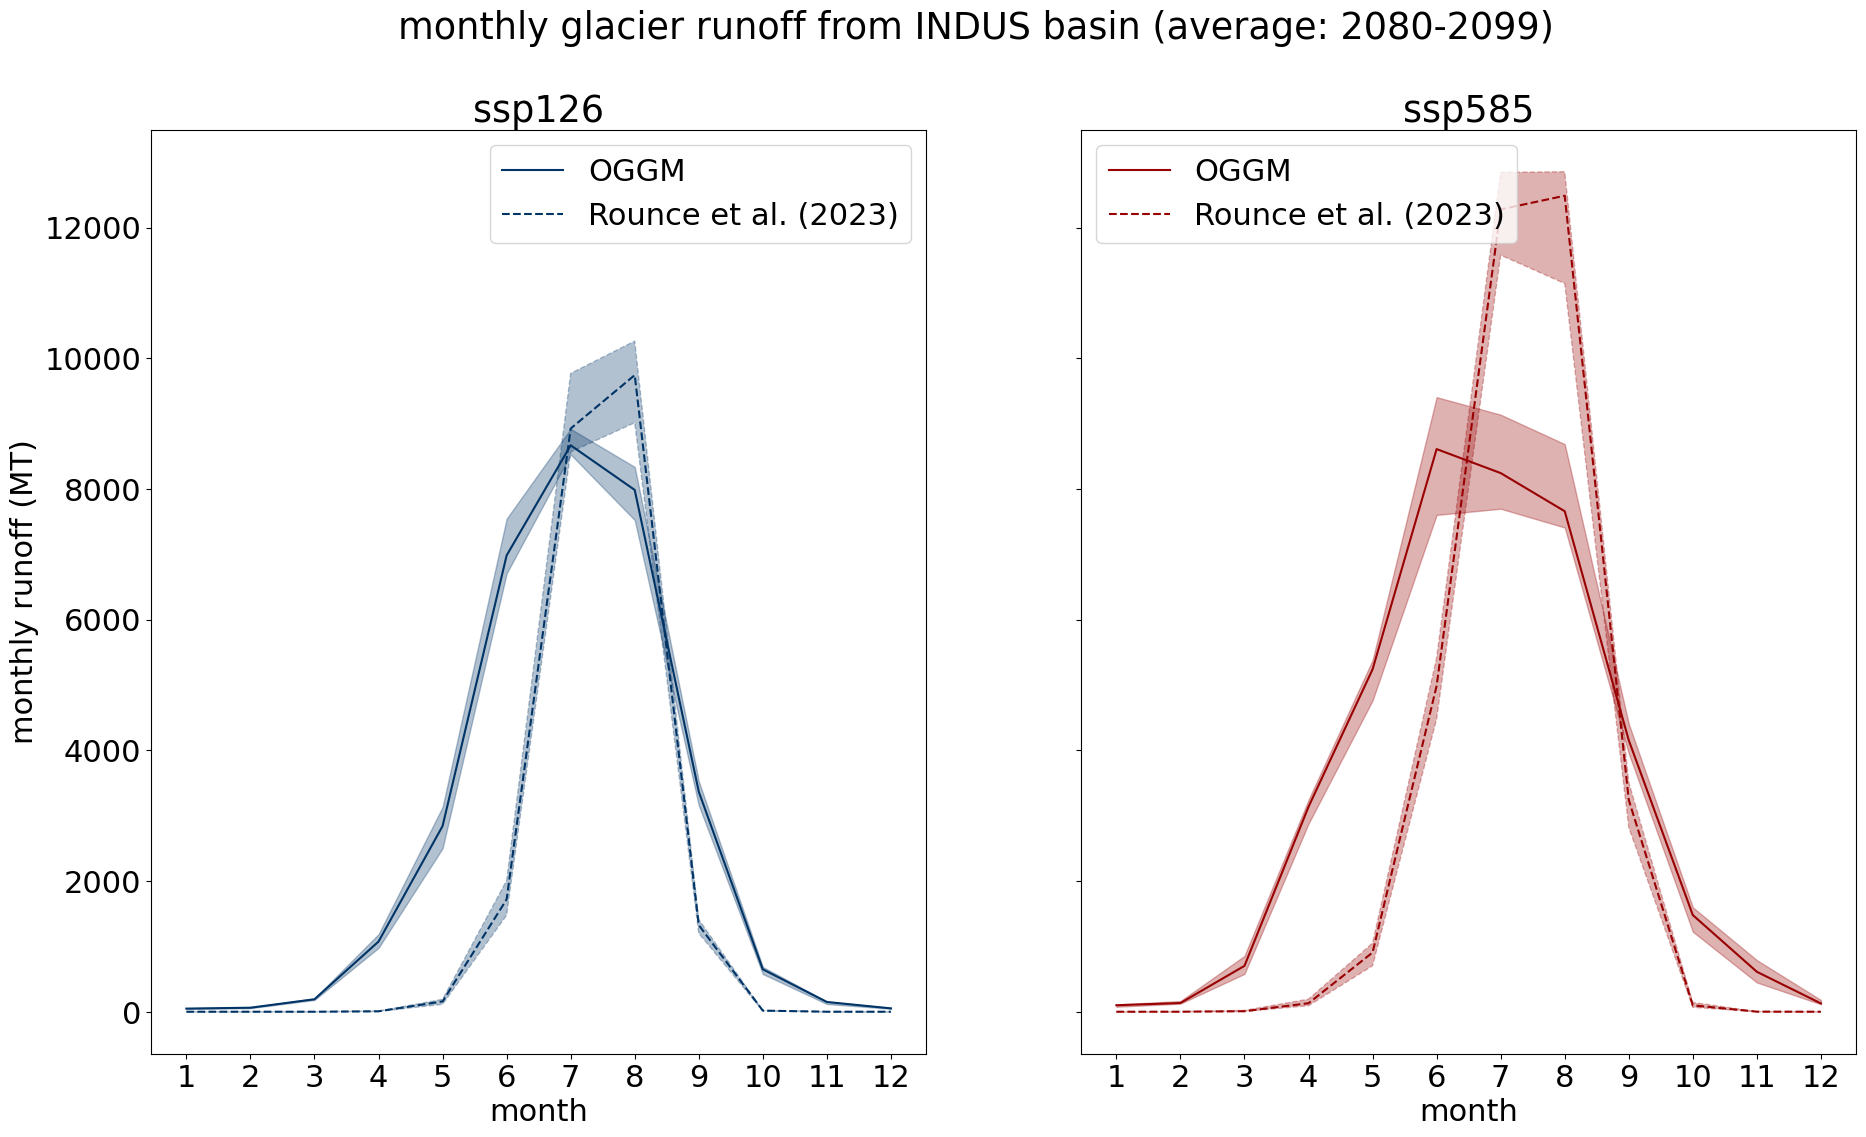

In [268]:
plt.rc('font', size=22)
colors_dict = {'ssp126': '#003466', 'ssp585':'#980002'}

for y0,y1 in zip([2020,2080], [2039,2099]):
    fig, axs = plt.subplots(1,2, figsize=(22,12), sharey=True, sharex=True)
    for ssp in ['ssp126', 'ssp585']:

        _db_l = []
        for gcm in gcms:
            # this is the file with data for every single glacier 
            db = xr.open_dataset(path_oggm_erik + f'oggm_compiled_{basin_idx}_{gcm}_{ssp}.nc')
            db = db.sel(time = slice(y0,y1))
            db['runoff'] = db['melt_off_glacier_monthly'] + db['melt_on_glacier_monthly'] + db['liq_prcp_off_glacier_monthly'] + db['liq_prcp_on_glacier_monthly']
            db = db.sel(rgi_id =db_rounce.rgi_id.values).runoff.sum(dim='rgi_id')/1e9
            db = db.mean(dim='time')
            db['gcm'] = gcm
            _db_l.append(db)
        db_oggm_erik_ssp = xr.concat(_db_l, dim='gcm')
        db_oggm_erik_ssp = db_oggm_erik_ssp.sortby('calendar_month_2d')
        #_db_gcm['ssp'] = ssp
        #_db_gcm_l.append(_db_gcm)
        #db_oggm_erik_ssp = xr.concat(_db_gcm_l, dim='ssp')


        #db_oggm_erik_ssp_sum = db_oggm_erik_ssp.groupby('time.year').sum()

        db_rounce = xr.open_dataset(f'runoff_rounce_{basin}_{ssp}_monthly.nc').glac_runoff_fixed_monthly/1e6 # m3 to Mega Tonnes
        db_rounce_yr_sum = db_rounce.sel(time=slice(f'{y0}-01-01', f'{y1}-12-01')).sum(dim='rgi_id')
        #db_rounce_yr_sum = db_rounce.sel(time = slice(y0,y1)).sum(dim='rgi_id')
        db_rounce_yr_sum = db_rounce_yr_sum.groupby('time.month').mean()


        if ssp == 'ssp126':
            ax = axs[0]
        else:
            ax = axs[1]

        ax.set_title(ssp)
        sns.lineplot(x='calendar_month_2d', y='runoff (MT)', data=db_oggm_erik_ssp.to_dataframe(name='runoff (MT)').reset_index(),
                     estimator=np.median, ax=ax,ci=None,
                     ls = '-', label='OGGM', color = colors_dict[ssp])
        ax.fill_between(db_oggm_erik_ssp.calendar_month_2d,
                     db_oggm_erik_ssp.quantile(0.25, dim='gcm').values,
                     db_oggm_erik_ssp.quantile(0.75, dim='gcm').values, alpha =0.3, ls = '-',color = colors_dict[ssp])
        sns.lineplot(x='month', y='runoff (MT)', data=db_rounce_yr_sum.to_dataframe(name='runoff (MT)').reset_index(),
                     estimator=np.median,ax=ax,ci=None,
                     ls = '--', label='Rounce et al. (2023)', color = colors_dict[ssp])
        ax.fill_between(db_rounce_yr_sum.month,
                     db_rounce_yr_sum.quantile(0.25, dim='gcm').values,
                     db_rounce_yr_sum.quantile(0.75, dim='gcm').values, alpha =0.3, ls = '--',color = colors_dict[ssp], label = 'IQR')
        ax.set_xticks(np.arange(1,13,1));


        #ax.set_ylim([18000,46000])
        ax.set_xlabel('month')
        if ssp == 'ssp126':
            ax.set_ylabel(f'monthly runoff (MT)')
        else:
            ax.set_ylabel('')
    #plt.tight_layout()
    plt.suptitle(f'monthly glacier runoff from {basin} basin (average: {y0}-{y1})')

### Other trials

<AxesSubplot:xlabel='year', ylabel='runoff (mm month-1)'>

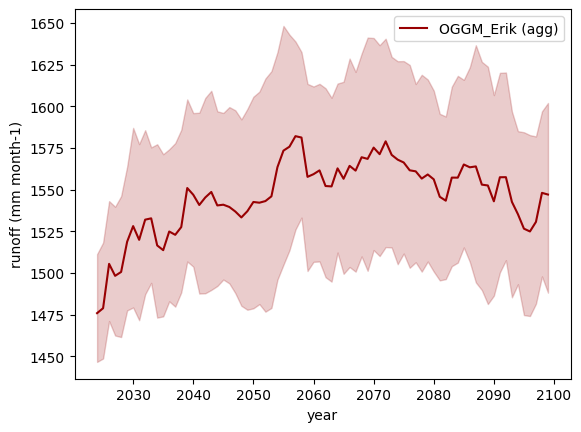

In [134]:
    ###
    _db_l = []
    for gcm in gcms:
        db = xr.open_dataset(path_oggm_erik+f'{basin_idx}_discharge_proj_{gcm}_{ssp}.nc')
        db = db.groupby('time.year').sum()
        db['gcm'] = gcm
        # this is in mm month-1
        db = db[['glacier_runoff', 'gcm']]
        _db_l.append(db)
    db_oggm_erik_sum_ssp = xr.concat(_db_l, dim='gcm')
    db_oggm_erik_sum_ssp = db_oggm_erik_sum_ssp.sel(year = slice(2020,2099)).glacier_runoff
    db_oggm_erik_sum_ssp = db_oggm_erik_sum_ssp.rolling({'year':5}).mean()
    
    sns.lineplot(x='year', y='runoff (mm month-1)', data=db_oggm_erik_sum_ssp.to_dataframe(name='runoff (mm month-1)').reset_index(),
                 ls = '-', label='OGGM_Erik (agg)', color = colors_dict[ssp])

In [12]:
_db_gcm_l = []
for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    _db_l = []
    for gcm in gcms:
        # this is the file with data for every single glacier 
        db = xr.open_dataset(path_oggm_erik+f'{basin_idx}_discharge_proj_{gcm}_{ssp}.nc')
        #db['runoff'] = db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier']
        #dbglacier_runoff
        db['gcm'] = gcm
        db = db[['glacier_runoff', 'gcm']]
        _db_l.append(db)

    db_oggm_erik_sum_ssp = xr.concat(_db_l, dim='gcm')

# has already the runoff (and some adjusted stuff)
#db = xr.open_dataset(path_oggm_erik+f'{basin_idx}_discharge_proj_{gcm}_{ssp}.nc')
# only has PET
# xr.open_dataset(path_oggm_erik + '2309_BCC-CSM2-MR_ssp126.nc')

TypeError: cannot compare cftime.DatetimeNoLeap(2020, 1, 16, 12, 0, 0, 0, has_year_zero=True) and Timestamp('2020-01-16 12:00:00') (different calendars)

In [8]:
db

<xarray.Dataset>
Dimensions:                   (time: 972)
Coordinates:
  * time                      (time) object 2020-01-16 12:00:00 ... 2100-12-1...
    month                     (time) int64 ...
    year                      (time) int64 ...
Data variables:
    prcp                      (time) float64 ...
    PET                       (time) float64 ...
    glacier_runoff            (time) float32 ...
    glacier_runoff_nofac      (time) float32 ...
    glacier_runoff_adj        (time) float64 ...
    glacier_runoff_adj_nofac  (time) float64 ...
    prcp_adj                  (time) float64 ...
    D                         (time) float64 ...
    D_adj                     (time) float64 ...
    D_adj_nofac               (time) float64 ...
Attributes:
    gcm:                 BCC-CSM2-MR_ssp126
    max glaciated area:  26291694000.0

In [21]:
db#.glacier_runoff

<xarray.Dataset>
Dimensions:                       (time: 81, rgi_id: 23424, month_2d: 12)
Coordinates:
  * time                          (time) float64 2.02e+03 2.021e+03 ... 2.1e+03
  * rgi_id                        (rgi_id) object 'RGI60-13.00002' ... 'RGI60...
    hydro_year                    (time) int64 ...
    hydro_month                   (time) int64 ...
    calendar_year                 (time) int64 ...
    calendar_month                (time) int64 ...
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 ...
    volume_bsl                    (time, rgi_id) float32 ...
    volume_bwl                    (time, rgi_id) float32 ...
    area                          (time, rgi_id) float32 ...
    length                        (time, rgi_id) float32 ...
    calving                       (time, rgi_id) float32 ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    water_level                   (rgi_id) float32 ...
    glen_a                        (rgi_id) float32 ...
    fs                            (rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.2
    calendar:       365-day no leap
    creation_date:  2021-10-19 16:57:59

In [15]:
db.glacier_runoff.groupby('time.year').sum()

<xarray.DataArray 'glacier_runoff' (year: 81)>
array([1419.7529, 1521.861 , 1539.1827, 1519.1991, 1646.0447, 1357.7666,
       1529.0192, 1644.2972, 1473.3912, 1645.3276, 1507.8579, 1444.3009,
       1284.3569, 1450.0841, 1486.779 , 1427.2823, 1504.4945, 1438.1185,
       1308.4275, 1607.2449, 1337.0426, 1522.8254, 1575.3405, 1374.9585,
       1537.5654, 1559.8712, 1390.764 , 1674.3567, 1420.5938, 1560.2672,
       1827.844 , 1372.9092, 1577.5342, 1490.4916, 1620.1671, 1503.2883,
       1324.624 , 1445.3851, 1609.6399, 1502.6619, 1399.5876, 1422.5944,
       1346.9691, 1282.4486, 1388.2607, 1435.6373, 1336.7617, 1342.1437,
       1248.9712, 1505.0847, 1248.3435, 1469.8102, 1114.7633, 1558.7113,
       1400.9601, 1360.7726, 1312.5115, 1533.4857, 1669.1787, 1173.8094,
       1386.818 , 1479.4722, 1148.2114, 1259.6659, 1342.435 , 1175.8828,
       1307.1123, 1237.6127, 1432.2024, 1123.2223, 1376.1476, 1450.1809,
       1239.796 , 1193.6906, 1146.5719, 1198.6334, 1374.1276, 1270.9683,
       1302.4999, 1405.1603,    0.    ], dtype=float32)
Coordinates:
  * year     (year) int64 2020 2021 2022 2023 2024 ... 2096 2097 2098 2099 2100